# 安裝套件

In [ ]:
pip install torch torchvision scikit-learn matplotlib tqdm seaborn

In [ ]:
pip install timm

# 前置動作

載入所需的Lib

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
import timm
import time

資料前處理

In [ ]:
# 設定隨機種子
torch.manual_seed(95920)
np.random.seed(95920)

# 定義資料夾路徑
CAPSULE_PATH = "capsule"
if not os.path.exists(CAPSULE_PATH):
    raise FileNotFoundError(f"資料夾 {CAPSULE_PATH} 不存在")

IMG_SIZE = 224
BATCH_SIZE = 128

# 資料增強與轉換(因為這次資料量少，所以不能使用太強烈的資料增強)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        self.class_names = sorted([
            d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        for cls_name in self.class_names:
            cls_folder = os.path.join(root_dir, cls_name)
            for img_file in os.listdir(cls_folder):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_folder, img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls_name])

        for cls_name, idx in self.class_to_idx.items():
            count = sum([1 for label in self.labels if label == idx])
            print(f"  {cls_name:15s} (label={idx}): {count} 張")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    

full_dataset = CustomImageDataset(root_dir=CAPSULE_PATH, transform=train_transforms)

# 分割 train/val（80/20）
indices = list(range(len(full_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=full_dataset.labels)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)


class_counts = [0] * len(full_dataset.class_names)
for _, label in full_dataset:
    class_counts[label] += 1
print("類別名稱與對應編號:", full_dataset.class_to_idx)
print("類別分佈:", class_counts)

print(f"總訓練資料數量: {len(full_dataset)}")
print(f"訓練集數量: {len(train_indices)}")
print(f"驗證集數量: {len(val_indices)}")

  crack           (label=0): 23 張
  faulty_imprint  (label=1): 22 張
  good            (label=2): 219 張
  poke            (label=3): 21 張
  scratch         (label=4): 23 張
  squeeze         (label=5): 20 張
類別名稱與對應編號: {'crack': 0, 'faulty_imprint': 1, 'good': 2, 'poke': 3, 'scratch': 4, 'squeeze': 5}
類別分佈: [23, 22, 219, 21, 23, 20]
總訓練資料數量: 328
訓練集數量: 262
驗證集數量: 66


# 自行搭建ResNet50

ResNet18 框架

In [3]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)

    def forward(self, x):
        avg_out = self.fc2(F.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(F.relu(self.fc1(self.max_pool(x))))
        return torch.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return torch.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.cbam = CBAM(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        out += identity
        return self.relu(out)


class SmallResNet_CBAM(nn.Module):
    def __init__(self, num_classes=6):
        super(SmallResNet_CBAM, self).__init__()
        self.in_channels = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 2, stride=1)
        self.layer2 = self._make_layer(64, 2, stride=2)
        self.layer3 = self._make_layer(128, 2, stride=2)
        self.layer4 = self._make_layer(256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

訓練階段

類別權重: tensor([2.3768, 2.4848, 0.2496, 2.6032, 2.3768, 2.7333], device='cuda:0')

Epoch [1/300]
Warmup LR: 0.000500


Epoch Time: 10.81 秒
Train Loss: 1.0335, Train Acc: 17.94%
Val Loss:   1.0393, Val Acc:   9.09%
--> 最佳模型保存 (Val Acc: 9.09%)

Epoch [2/300]
Warmup LR: 0.001000


Epoch Time: 10.51 秒
Train Loss: 1.0211, Train Acc: 29.01%
Val Loss:   1.0471, Val Acc:   6.06%

Epoch [3/300]
Warmup LR: 0.001500


Epoch Time: 10.55 秒
Train Loss: 0.9956, Train Acc: 16.03%
Val Loss:   1.0643, Val Acc:   6.06%

Epoch [4/300]
Current LR: 0.001500


Epoch Time: 10.51 秒
Train Loss: 0.9885, Train Acc: 24.43%
Val Loss:   1.1354, Val Acc:   7.58%

Epoch [5/300]
Current LR: 0.001500


Epoch Time: 10.49 秒
Train Loss: 0.9885, Train Acc: 31.68%
Val Loss:   1.4834, Val Acc:   6.06%

Epoch [6/300]
Current LR: 0.001500


Epoch Time: 10.23 秒
Train Loss: 1.0590, Train Acc: 18.70%
Val Loss:   1.7492, Val Acc:   6.06%

Epoch [7/300]
Current LR: 0.001500


Epoch Time: 10.51 秒
Train Loss: 1.0406, Train Acc: 17.94%
Val Loss:   1.8471, Val Acc:   6.06%

Epoch [8/300]
Current LR: 0.001499


Epoch Time: 10.46 秒
Train Loss: 1.0514, Train Acc: 12.98%
Val Loss:   1.1696, Val Acc:   6.06%

Epoch [9/300]
Current LR: 0.001499


Epoch Time: 10.61 秒
Train Loss: 0.9729, Train Acc: 14.12%
Val Loss:   1.3350, Val Acc:   6.06%

Epoch [10/300]
Current LR: 0.001498


Epoch Time: 10.59 秒
Train Loss: 0.9846, Train Acc: 19.47%
Val Loss:   1.3065, Val Acc:   6.06%

Epoch [11/300]
Current LR: 0.001498


Epoch Time: 10.59 秒
Train Loss: 0.9483, Train Acc: 19.85%
Val Loss:   1.1982, Val Acc:   6.06%

Epoch [12/300]
Current LR: 0.001497


Epoch Time: 10.41 秒
Train Loss: 0.8958, Train Acc: 27.48%
Val Loss:   1.0795, Val Acc:   10.61%
--> 最佳模型保存 (Val Acc: 10.61%)

Epoch [13/300]
Current LR: 0.001497


Epoch Time: 10.60 秒
Train Loss: 0.8977, Train Acc: 23.66%
Val Loss:   1.0368, Val Acc:   16.67%
--> 最佳模型保存 (Val Acc: 16.67%)

Epoch [14/300]
Current LR: 0.001496


Epoch Time: 10.61 秒
Train Loss: 0.8739, Train Acc: 23.66%
Val Loss:   1.1255, Val Acc:   16.67%

Epoch [15/300]
Current LR: 0.001495


Epoch Time: 10.63 秒
Train Loss: 0.8485, Train Acc: 21.37%
Val Loss:   1.0308, Val Acc:   13.64%

Epoch [16/300]
Current LR: 0.001494


Epoch Time: 10.61 秒
Train Loss: 0.8112, Train Acc: 26.34%
Val Loss:   0.8850, Val Acc:   19.70%
--> 最佳模型保存 (Val Acc: 19.70%)

Epoch [17/300]
Current LR: 0.001493


Epoch Time: 10.60 秒
Train Loss: 0.7933, Train Acc: 25.95%
Val Loss:   1.0063, Val Acc:   62.12%
--> 最佳模型保存 (Val Acc: 62.12%)

Epoch [18/300]
Current LR: 0.001492


Epoch Time: 10.60 秒
Train Loss: 0.7911, Train Acc: 38.93%
Val Loss:   1.7584, Val Acc:   66.67%
--> 最佳模型保存 (Val Acc: 66.67%)

Epoch [19/300]
Current LR: 0.001491


Epoch Time: 10.62 秒
Train Loss: 0.7924, Train Acc: 24.81%
Val Loss:   1.9716, Val Acc:   69.70%
--> 最佳模型保存 (Val Acc: 69.70%)

Epoch [20/300]
Current LR: 0.001489


Epoch Time: 10.49 秒
Train Loss: 0.8264, Train Acc: 14.89%
Val Loss:   1.9958, Val Acc:   69.70%

Epoch [21/300]
Current LR: 0.001488


Epoch Time: 10.43 秒
Train Loss: 0.7787, Train Acc: 21.37%
Val Loss:   1.5346, Val Acc:   69.70%

Epoch [22/300]
Current LR: 0.001486


Epoch Time: 10.24 秒
Train Loss: 0.7740, Train Acc: 27.10%
Val Loss:   2.0126, Val Acc:   63.64%

Epoch [23/300]
Current LR: 0.001485


Epoch Time: 10.00 秒
Train Loss: 0.7414, Train Acc: 32.44%
Val Loss:   2.1219, Val Acc:   45.45%

Epoch [24/300]
Current LR: 0.001483


Epoch Time: 10.18 秒
Train Loss: 0.7491, Train Acc: 28.24%
Val Loss:   1.9553, Val Acc:   57.58%

Epoch [25/300]
Current LR: 0.001482


Epoch Time: 10.50 秒
Train Loss: 0.7270, Train Acc: 27.10%
Val Loss:   0.7995, Val Acc:   71.21%
--> 最佳模型保存 (Val Acc: 71.21%)

Epoch [26/300]
Current LR: 0.001480


Epoch Time: 10.60 秒
Train Loss: 0.7080, Train Acc: 29.01%
Val Loss:   0.8060, Val Acc:   19.70%

Epoch [27/300]
Current LR: 0.001478


Epoch Time: 10.35 秒
Train Loss: 0.7138, Train Acc: 29.01%
Val Loss:   0.7882, Val Acc:   12.12%

Epoch [28/300]
Current LR: 0.001476


Epoch Time: 10.22 秒
Train Loss: 0.7129, Train Acc: 26.72%
Val Loss:   3.5708, Val Acc:   6.06%

Epoch [29/300]
Current LR: 0.001474


Epoch Time: 10.48 秒
Train Loss: 0.7321, Train Acc: 51.15%
Val Loss:   4.1072, Val Acc:   6.06%

Epoch [30/300]
Current LR: 0.001472


Epoch Time: 10.56 秒
Train Loss: 0.6849, Train Acc: 55.34%
Val Loss:   1.3794, Val Acc:   6.06%

Epoch [31/300]
Current LR: 0.001470


Epoch Time: 10.53 秒
Train Loss: 0.6571, Train Acc: 48.85%
Val Loss:   1.0503, Val Acc:   7.58%

Epoch [32/300]
Current LR: 0.001467


Epoch Time: 10.56 秒
Train Loss: 0.6552, Train Acc: 41.22%
Val Loss:   0.8232, Val Acc:   16.67%

Epoch [33/300]
Current LR: 0.001465


Epoch Time: 10.54 秒
Train Loss: 0.6986, Train Acc: 38.17%
Val Loss:   0.9865, Val Acc:   19.70%

Epoch [34/300]
Current LR: 0.001463


Epoch Time: 10.41 秒
Train Loss: 0.7380, Train Acc: 28.63%
Val Loss:   0.9900, Val Acc:   18.18%

Epoch [35/300]
Current LR: 0.001460


Epoch Time: 10.68 秒
Train Loss: 0.7175, Train Acc: 27.86%
Val Loss:   0.8594, Val Acc:   19.70%

Epoch [36/300]
Current LR: 0.001458


Epoch Time: 10.64 秒
Train Loss: 0.7157, Train Acc: 38.17%
Val Loss:   5.0384, Val Acc:   60.61%

Epoch [37/300]
Current LR: 0.001455


Epoch Time: 10.83 秒
Train Loss: 0.6688, Train Acc: 50.76%
Val Loss:   21.0462, Val Acc:   65.15%

Epoch [38/300]
Current LR: 0.001452


Epoch Time: 10.43 秒
Train Loss: 0.7165, Train Acc: 61.83%
Val Loss:   25.4843, Val Acc:   65.15%

Epoch [39/300]
Current LR: 0.001449


Epoch Time: 10.22 秒
Train Loss: 0.6524, Train Acc: 47.71%
Val Loss:   34.3706, Val Acc:   7.58%

Epoch [40/300]
Current LR: 0.001446


Epoch Time: 10.34 秒
Train Loss: 0.6324, Train Acc: 40.08%
Val Loss:   18.1851, Val Acc:   68.18%

Epoch [41/300]
Current LR: 0.001443


Epoch Time: 10.77 秒
Train Loss: 0.5953, Train Acc: 37.02%
Val Loss:   11.5496, Val Acc:   66.67%

Epoch [42/300]
Current LR: 0.001440


Epoch Time: 10.62 秒
Train Loss: 0.7212, Train Acc: 37.02%
Val Loss:   23.4209, Val Acc:   66.67%

Epoch [43/300]
Current LR: 0.001437


Epoch Time: 10.76 秒
Train Loss: 0.7137, Train Acc: 29.39%
Val Loss:   27.3895, Val Acc:   66.67%

Epoch [44/300]
Current LR: 0.001434


Epoch Time: 10.45 秒
Train Loss: 0.6879, Train Acc: 32.06%
Val Loss:   39.7120, Val Acc:   66.67%

Epoch [45/300]
Current LR: 0.001431


Epoch Time: 10.41 秒
Train Loss: 0.6635, Train Acc: 37.02%
Val Loss:   40.8502, Val Acc:   66.67%

Epoch [46/300]
Current LR: 0.001427


Epoch Time: 10.47 秒
Train Loss: 0.6818, Train Acc: 48.47%
Val Loss:   12.1485, Val Acc:   66.67%

Epoch [47/300]
Current LR: 0.001424


Epoch Time: 10.56 秒
Train Loss: 0.7485, Train Acc: 22.52%
Val Loss:   2.1319, Val Acc:   66.67%

Epoch [48/300]
Current LR: 0.001420


Epoch Time: 10.55 秒
Train Loss: 0.8006, Train Acc: 23.28%
Val Loss:   2.4839, Val Acc:   66.67%

Epoch [49/300]
Current LR: 0.001417


Epoch Time: 10.55 秒
Train Loss: 0.8118, Train Acc: 26.34%
Val Loss:   2.9978, Val Acc:   66.67%

Epoch [50/300]
Current LR: 0.001413


Epoch Time: 10.55 秒
Train Loss: 0.7952, Train Acc: 19.47%
Val Loss:   0.9258, Val Acc:   63.64%
--> 模型保存至 custom_resnet_checkpoints/model_epoch_50.pth

Epoch [51/300]
Current LR: 0.001410


Epoch Time: 10.59 秒
Train Loss: 0.7393, Train Acc: 23.66%
Val Loss:   0.7510, Val Acc:   31.82%

Epoch [52/300]
Current LR: 0.001406


Epoch Time: 10.36 秒
Train Loss: 0.7170, Train Acc: 32.06%
Val Loss:   0.8874, Val Acc:   71.21%

Epoch [53/300]
Current LR: 0.001402


Epoch Time: 10.55 秒
Train Loss: 0.6915, Train Acc: 46.56%
Val Loss:   2.2638, Val Acc:   66.67%

Epoch [54/300]
Current LR: 0.001398


Epoch Time: 10.62 秒
Train Loss: 0.6741, Train Acc: 59.92%
Val Loss:   0.7986, Val Acc:   56.06%

Epoch [55/300]
Current LR: 0.001394


Epoch Time: 10.63 秒
Train Loss: 0.6425, Train Acc: 57.25%
Val Loss:   1.2073, Val Acc:   69.70%

Epoch [56/300]
Current LR: 0.001390


Epoch Time: 10.59 秒
Train Loss: 0.6058, Train Acc: 60.69%
Val Loss:   0.8111, Val Acc:   12.12%

Epoch [57/300]
Current LR: 0.001386


Epoch Time: 10.57 秒
Train Loss: 0.5767, Train Acc: 50.76%
Val Loss:   0.6811, Val Acc:   53.03%

Epoch [58/300]
Current LR: 0.001381


Epoch Time: 10.44 秒
Train Loss: 0.5779, Train Acc: 39.69%
Val Loss:   9.4564, Val Acc:   66.67%

Epoch [59/300]
Current LR: 0.001377


Epoch Time: 10.51 秒
Train Loss: 0.6019, Train Acc: 45.42%
Val Loss:   4.3901, Val Acc:   66.67%

Epoch [60/300]
Current LR: 0.001373


Epoch Time: 10.57 秒
Train Loss: 0.5991, Train Acc: 54.58%
Val Loss:   1.4308, Val Acc:   16.67%

Epoch [61/300]
Current LR: 0.001368


Epoch Time: 10.63 秒
Train Loss: 0.6317, Train Acc: 53.82%
Val Loss:   0.8644, Val Acc:   22.73%

Epoch [62/300]
Current LR: 0.001364


Epoch Time: 10.47 秒
Train Loss: 0.5982, Train Acc: 53.82%
Val Loss:   0.9120, Val Acc:   71.21%

Epoch [63/300]
Current LR: 0.001359


Epoch Time: 10.66 秒
Train Loss: 0.5954, Train Acc: 59.16%
Val Loss:   0.8112, Val Acc:   13.64%

Epoch [64/300]
Current LR: 0.001354


Epoch Time: 10.64 秒
Train Loss: 0.5838, Train Acc: 49.24%
Val Loss:   0.8086, Val Acc:   16.67%

Epoch [65/300]
Current LR: 0.001350


Epoch Time: 10.59 秒
Train Loss: 0.5343, Train Acc: 49.24%
Val Loss:   5.0705, Val Acc:   69.70%

Epoch [66/300]
Current LR: 0.001345


Epoch Time: 10.65 秒
Train Loss: 0.5589, Train Acc: 45.42%
Val Loss:   2.7380, Val Acc:   62.12%

Epoch [67/300]
Current LR: 0.001340


Epoch Time: 10.63 秒
Train Loss: 0.5458, Train Acc: 49.24%
Val Loss:   2.6025, Val Acc:   62.12%

Epoch [68/300]
Current LR: 0.001335


Epoch Time: 10.60 秒
Train Loss: 0.5192, Train Acc: 59.54%
Val Loss:   1.4027, Val Acc:   28.79%

Epoch [69/300]
Current LR: 0.001330


Epoch Time: 10.68 秒
Train Loss: 0.5119, Train Acc: 61.07%
Val Loss:   2.2599, Val Acc:   69.70%

Epoch [70/300]
Current LR: 0.001325


Epoch Time: 10.61 秒
Train Loss: 0.5081, Train Acc: 62.98%
Val Loss:   9.1102, Val Acc:   66.67%

Epoch [71/300]
Current LR: 0.001320


Epoch Time: 10.77 秒
Train Loss: 0.5772, Train Acc: 59.16%
Val Loss:   20.9952, Val Acc:   66.67%

Epoch [72/300]
Current LR: 0.001315


Epoch Time: 10.68 秒
Train Loss: 0.6355, Train Acc: 52.29%
Val Loss:   15.0017, Val Acc:   66.67%

Epoch [73/300]
Current LR: 0.001310


Epoch Time: 10.56 秒
Train Loss: 0.5997, Train Acc: 36.64%
Val Loss:   3.4912, Val Acc:   69.70%

Epoch [74/300]
Current LR: 0.001304


Epoch Time: 10.59 秒
Train Loss: 0.5321, Train Acc: 41.22%
Val Loss:   1.1605, Val Acc:   15.15%

Epoch [75/300]
Current LR: 0.001299


Epoch Time: 10.60 秒
Train Loss: 0.5870, Train Acc: 43.51%
Val Loss:   0.8228, Val Acc:   21.21%

Epoch [76/300]
Current LR: 0.001293


Epoch Time: 10.61 秒
Train Loss: 0.5455, Train Acc: 48.85%
Val Loss:   1.2775, Val Acc:   12.12%

Epoch [77/300]
Current LR: 0.001288


Epoch Time: 10.66 秒
Train Loss: 0.6015, Train Acc: 52.29%
Val Loss:   0.7434, Val Acc:   56.06%

Epoch [78/300]
Current LR: 0.001282


Epoch Time: 10.58 秒
Train Loss: 0.5855, Train Acc: 58.40%
Val Loss:   14.5935, Val Acc:   66.67%

Epoch [79/300]
Current LR: 0.001277


Epoch Time: 10.66 秒
Train Loss: 0.6231, Train Acc: 58.40%
Val Loss:   19.1059, Val Acc:   71.21%

Epoch [80/300]
Current LR: 0.001271


Epoch Time: 10.61 秒
Train Loss: 0.6756, Train Acc: 52.29%
Val Loss:   21.5155, Val Acc:   6.06%

Epoch [81/300]
Current LR: 0.001265


Epoch Time: 10.61 秒
Train Loss: 0.6324, Train Acc: 32.06%
Val Loss:   14.4568, Val Acc:   6.06%

Epoch [82/300]
Current LR: 0.001260


Epoch Time: 10.65 秒
Train Loss: 0.6073, Train Acc: 34.35%
Val Loss:   5.2001, Val Acc:   6.06%

Epoch [83/300]
Current LR: 0.001254


Epoch Time: 10.58 秒
Train Loss: 0.5582, Train Acc: 37.79%
Val Loss:   3.0632, Val Acc:   34.85%

Epoch [84/300]
Current LR: 0.001248


Epoch Time: 10.60 秒
Train Loss: 0.5439, Train Acc: 53.82%
Val Loss:   0.6144, Val Acc:   39.39%

Epoch [85/300]
Current LR: 0.001242


Epoch Time: 10.62 秒
Train Loss: 0.5345, Train Acc: 56.87%
Val Loss:   0.7440, Val Acc:   15.15%

Epoch [86/300]
Current LR: 0.001236


Epoch Time: 10.63 秒
Train Loss: 0.5761, Train Acc: 62.98%
Val Loss:   0.8714, Val Acc:   13.64%

Epoch [87/300]
Current LR: 0.001230


Epoch Time: 10.61 秒
Train Loss: 0.5666, Train Acc: 70.61%
Val Loss:   1.1711, Val Acc:   10.61%

Epoch [88/300]
Current LR: 0.001224


Epoch Time: 10.36 秒
Train Loss: 0.5256, Train Acc: 66.41%
Val Loss:   1.6899, Val Acc:   10.61%

Epoch [89/300]
Current LR: 0.001218


Epoch Time: 10.33 秒
Train Loss: 0.5306, Train Acc: 58.78%
Val Loss:   1.9937, Val Acc:   13.64%

Epoch [90/300]
Current LR: 0.001211


Epoch Time: 10.57 秒
Train Loss: 0.5140, Train Acc: 64.12%
Val Loss:   2.1712, Val Acc:   12.12%

Epoch [91/300]
Current LR: 0.001205


Epoch Time: 10.58 秒
Train Loss: 0.5481, Train Acc: 59.54%
Val Loss:   1.0010, Val Acc:   22.73%

Epoch [92/300]
Current LR: 0.001199


Epoch Time: 10.59 秒
Train Loss: 0.6057, Train Acc: 52.67%
Val Loss:   0.9981, Val Acc:   15.15%

Epoch [93/300]
Current LR: 0.001193


Epoch Time: 10.64 秒
Train Loss: 0.5049, Train Acc: 58.40%
Val Loss:   0.9926, Val Acc:   13.64%

Epoch [94/300]
Current LR: 0.001186


Epoch Time: 10.62 秒
Train Loss: 0.5043, Train Acc: 56.87%
Val Loss:   1.1175, Val Acc:   12.12%

Epoch [95/300]
Current LR: 0.001180


Epoch Time: 10.53 秒
Train Loss: 0.5041, Train Acc: 62.60%
Val Loss:   1.6469, Val Acc:   12.12%

Epoch [96/300]
Current LR: 0.001173


Epoch Time: 10.59 秒
Train Loss: 0.5142, Train Acc: 62.21%
Val Loss:   1.9382, Val Acc:   9.09%

Epoch [97/300]
Current LR: 0.001167


Epoch Time: 10.63 秒
Train Loss: 0.5082, Train Acc: 66.79%
Val Loss:   1.2186, Val Acc:   16.67%

Epoch [98/300]
Current LR: 0.001160


Epoch Time: 10.49 秒
Train Loss: 0.5314, Train Acc: 67.94%
Val Loss:   1.5663, Val Acc:   9.09%

Epoch [99/300]
Current LR: 0.001153


Epoch Time: 10.51 秒
Train Loss: 0.5731, Train Acc: 59.54%
Val Loss:   1.6320, Val Acc:   9.09%

Epoch [100/300]
Current LR: 0.001147


Epoch Time: 10.40 秒
Train Loss: 0.5230, Train Acc: 50.76%
Val Loss:   1.3497, Val Acc:   9.09%
--> 模型保存至 custom_resnet_checkpoints/model_epoch_100.pth

Epoch [101/300]
Current LR: 0.001140


Epoch Time: 10.59 秒
Train Loss: 0.5353, Train Acc: 55.34%
Val Loss:   0.9986, Val Acc:   10.61%

Epoch [102/300]
Current LR: 0.001133


Epoch Time: 10.72 秒
Train Loss: 0.4991, Train Acc: 53.05%
Val Loss:   0.6110, Val Acc:   33.33%

Epoch [103/300]
Current LR: 0.001126


Epoch Time: 10.82 秒
Train Loss: 0.5196, Train Acc: 50.76%
Val Loss:   3.8020, Val Acc:   68.18%

Epoch [104/300]
Current LR: 0.001119


Epoch Time: 10.84 秒
Train Loss: 0.5082, Train Acc: 53.82%
Val Loss:   2.8148, Val Acc:   68.18%

Epoch [105/300]
Current LR: 0.001112


Epoch Time: 10.93 秒
Train Loss: 0.4992, Train Acc: 52.67%
Val Loss:   0.6556, Val Acc:   54.55%

Epoch [106/300]
Current LR: 0.001106


Epoch Time: 10.95 秒
Train Loss: 0.4960, Train Acc: 54.96%
Val Loss:   0.9782, Val Acc:   63.64%

Epoch [107/300]
Current LR: 0.001099


Epoch Time: 10.92 秒
Train Loss: 0.5605, Train Acc: 59.92%
Val Loss:   14.9669, Val Acc:   66.67%

Epoch [108/300]
Current LR: 0.001092


Epoch Time: 10.43 秒
Train Loss: 0.4959, Train Acc: 58.02%
Val Loss:   16.0238, Val Acc:   66.67%

Epoch [109/300]
Current LR: 0.001084


Epoch Time: 10.02 秒
Train Loss: 0.5337, Train Acc: 64.12%
Val Loss:   19.6332, Val Acc:   66.67%

Epoch [110/300]
Current LR: 0.001077


Epoch Time: 10.11 秒
Train Loss: 0.5161, Train Acc: 63.36%
Val Loss:   37.6598, Val Acc:   66.67%

Epoch [111/300]
Current LR: 0.001070


Epoch Time: 10.61 秒
Train Loss: 0.5785, Train Acc: 59.16%
Val Loss:   25.1246, Val Acc:   66.67%

Epoch [112/300]
Current LR: 0.001063


Epoch Time: 10.41 秒
Train Loss: 0.5811, Train Acc: 52.67%
Val Loss:   13.9516, Val Acc:   66.67%

Epoch [113/300]
Current LR: 0.001056


Epoch Time: 10.57 秒
Train Loss: 0.5699, Train Acc: 53.82%
Val Loss:   7.9034, Val Acc:   66.67%

Epoch [114/300]
Current LR: 0.001049


Epoch Time: 10.55 秒
Train Loss: 0.5555, Train Acc: 54.96%
Val Loss:   3.2220, Val Acc:   69.70%

Epoch [115/300]
Current LR: 0.001041


Epoch Time: 10.63 秒
Train Loss: 0.6098, Train Acc: 52.29%
Val Loss:   1.2919, Val Acc:   68.18%

Epoch [116/300]
Current LR: 0.001034


Epoch Time: 10.63 秒
Train Loss: 0.5480, Train Acc: 56.49%
Val Loss:   2.5489, Val Acc:   69.70%

Epoch [117/300]
Current LR: 0.001027


Epoch Time: 10.72 秒
Train Loss: 0.5704, Train Acc: 58.40%
Val Loss:   2.7346, Val Acc:   69.70%

Epoch [118/300]
Current LR: 0.001019


Epoch Time: 10.24 秒
Train Loss: 0.6001, Train Acc: 60.31%
Val Loss:   3.9529, Val Acc:   68.18%

Epoch [119/300]
Current LR: 0.001012


Epoch Time: 9.99 秒
Train Loss: 0.5473, Train Acc: 62.98%
Val Loss:   5.1930, Val Acc:   68.18%

Epoch [120/300]
Current LR: 0.001004


Epoch Time: 10.12 秒
Train Loss: 0.5812, Train Acc: 56.11%
Val Loss:   4.2372, Val Acc:   68.18%

Epoch [121/300]
Current LR: 0.000997


Epoch Time: 10.58 秒
Train Loss: 0.5555, Train Acc: 56.87%
Val Loss:   2.8340, Val Acc:   69.70%

Epoch [122/300]
Current LR: 0.000989


Epoch Time: 10.67 秒
Train Loss: 0.5219, Train Acc: 57.63%
Val Loss:   2.0447, Val Acc:   69.70%

Epoch [123/300]
Current LR: 0.000982


Epoch Time: 10.61 秒
Train Loss: 0.5131, Train Acc: 61.07%
Val Loss:   3.9791, Val Acc:   68.18%

Epoch [124/300]
Current LR: 0.000974


Epoch Time: 10.66 秒
Train Loss: 0.5147, Train Acc: 57.63%
Val Loss:   1.6795, Val Acc:   71.21%

Epoch [125/300]
Current LR: 0.000967


Epoch Time: 10.64 秒
Train Loss: 0.4827, Train Acc: 56.49%
Val Loss:   1.4627, Val Acc:   13.64%
--> 早停於 Epoch 125, 最佳 Val Acc: 71.21% (Epoch 25)
總訓練時間（至早停）：1318.47 秒 ≈ 21.97 分鐘


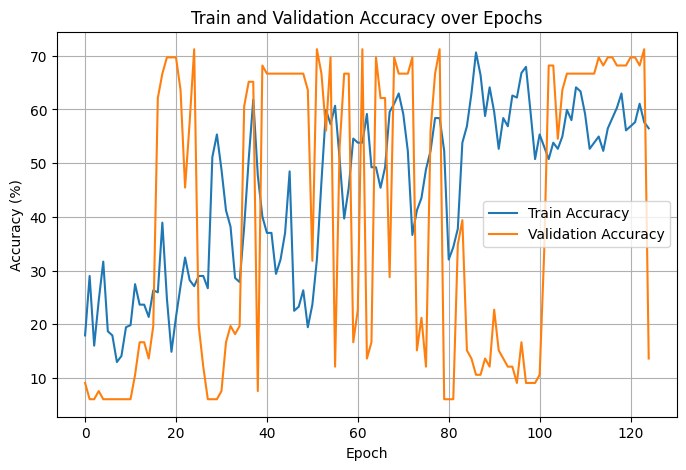

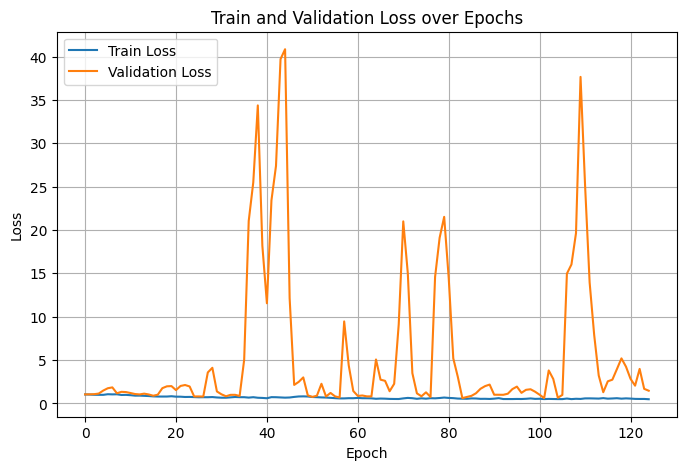

訓練完成！最佳 Val Acc: 71.21% (Epoch 25)
總訓練時間：1318.47 秒 ≈ 21.97 分鐘


In [4]:
# 訓練設置
epoch_times = []
NUM_EPOCHS = 300
LEARNING_RATE = 0.0015
PATIENCE = 100
MODEL_SAVE_PATH = "best_custom_resnet_.pth"
CHECKPOINT_DIR = "custom_resnet_checkpoints"

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Focal Loss 損失函數 
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def train_one_epoch(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loader_tqdm.set_postfix(loss=loss.item())

    val_loss = running_loss / total
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

def compute_class_weights(dataset, device):
    label_list = dataset.labels
    counter = Counter(label_list)
    num_classes = len(counter)
    total_samples = sum(counter.values())
    class_counts = [counter[i] for i in range(num_classes)]
    weights = [total_samples / (num_classes * c) for c in class_counts]
    return torch.tensor(weights, dtype=torch.float).to(device)


def train_model(model, train_loader, val_loader, device):
    class_weights = compute_class_weights(train_loader.dataset, device)
    print("類別權重:", class_weights)

    criterion = FocalLoss(gamma=3.0, alpha=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

    warmup_epochs = 3
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - warmup_epochs, eta_min=5e-6)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None  
        start_time = time.time() 
        
        if epoch < warmup_epochs:
            lr = LEARNING_RATE * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print(f"Warmup LR: {lr:.6f}")
        else:
            print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None 
        elapsed_time = time.time() - start_time
        epoch_times.append(elapsed_time)  
        print(f"Epoch Time: {elapsed_time:.2f} 秒")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")

        if (epoch + 1) % 50 == 0:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"--> 模型保存至 {checkpoint_path}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc 
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"--> 最佳模型保存 (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                total_time = sum(epoch_times)
                print(f"--> 早停於 Epoch {epoch+1}, 最佳 Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
                print(f"總訓練時間（至早停）：{total_time:.2f} 秒 ≈ {total_time/60:.2f} 分鐘")
                break
            
        if epoch >= warmup_epochs:
            scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_acc, best_epoch, epoch_times

def plot_accuracies(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('Image/custom_resnet_accuracy_plot.png')
    plt.show()
    
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('Image/custom_resnet_loss_plot.png')
    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SmallResNet_CBAM(num_classes=6).to(device)
    train_losses, val_losses, train_accuracies, val_accuracies, best_val_acc, best_epoch, epoch_times = train_model(
        model, train_loader, val_loader, device
    )
    plot_accuracies(train_accuracies, val_accuracies)
    plot_losses(train_losses, val_losses)
    print(f"訓練完成！最佳 Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"總訓練時間：{sum(epoch_times):.2f} 秒 ≈ {sum(epoch_times)/60:.2f} 分鐘")

# 預訓練的 ResNet18

In [3]:
def get_pretrained_resnet18(num_classes=6, freeze_backbone=False):
    model = timm.create_model("resnet18", pretrained=True, num_classes=6)
     
    if freeze_backbone:   #只凍結 backbone，訓練後面幾層而已
        for param in model.parameters():
            param.requires_grad = False
            
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    if freeze_backbone:
        for param in model.fc.parameters():
            param.requires_grad = True
    return model

類別權重: tensor([2.3768, 2.4848, 0.2496, 2.6032, 2.3768, 2.7333], device='cuda:0')

Epoch [1/300]
Warmup LR: 0.000100


Epoch Time: 9.91 秒
Train Loss: 1.0381, Train Acc: 22.52%
Val Loss:   1.0519, Val Acc:   13.64%
--> 最佳模型保存 (Val Acc: 13.64%)

Epoch [2/300]
Warmup LR: 0.000200


Epoch Time: 9.46 秒
Train Loss: 1.0194, Train Acc: 31.30%
Val Loss:   1.0493, Val Acc:   27.27%
--> 最佳模型保存 (Val Acc: 27.27%)

Epoch [3/300]
Warmup LR: 0.000300


Epoch Time: 9.47 秒
Train Loss: 0.9762, Train Acc: 45.80%
Val Loss:   1.0505, Val Acc:   39.39%
--> 最佳模型保存 (Val Acc: 39.39%)

Epoch [4/300]
Current LR: 0.000300


Epoch Time: 9.34 秒
Train Loss: 0.9568, Train Acc: 51.91%
Val Loss:   1.0570, Val Acc:   24.24%

Epoch [5/300]
Current LR: 0.000300


Epoch Time: 9.31 秒
Train Loss: 0.9477, Train Acc: 56.11%
Val Loss:   1.0542, Val Acc:   34.85%

Epoch [6/300]
Current LR: 0.000300


Epoch Time: 9.32 秒
Train Loss: 0.8957, Train Acc: 64.50%
Val Loss:   1.0434, Val Acc:   59.09%
--> 最佳模型保存 (Val Acc: 59.09%)

Epoch [7/300]
Current LR: 0.000300


Epoch Time: 9.48 秒
Train Loss: 0.8567, Train Acc: 72.90%
Val Loss:   1.0258, Val Acc:   60.61%
--> 最佳模型保存 (Val Acc: 60.61%)

Epoch [8/300]
Current LR: 0.000300


Epoch Time: 9.46 秒
Train Loss: 0.8457, Train Acc: 76.34%
Val Loss:   1.0263, Val Acc:   50.00%

Epoch [9/300]
Current LR: 0.000300


Epoch Time: 9.27 秒
Train Loss: 0.8145, Train Acc: 75.95%
Val Loss:   0.9976, Val Acc:   68.18%
--> 最佳模型保存 (Val Acc: 68.18%)

Epoch [10/300]
Current LR: 0.000300


Epoch Time: 9.45 秒
Train Loss: 0.8203, Train Acc: 64.50%
Val Loss:   0.9719, Val Acc:   54.55%

Epoch [11/300]
Current LR: 0.000300


Epoch Time: 9.40 秒
Train Loss: 0.7881, Train Acc: 56.49%
Val Loss:   0.9517, Val Acc:   50.00%

Epoch [12/300]
Current LR: 0.000299


Epoch Time: 9.45 秒
Train Loss: 0.7419, Train Acc: 58.78%
Val Loss:   0.9596, Val Acc:   59.09%

Epoch [13/300]
Current LR: 0.000299


Epoch Time: 9.34 秒
Train Loss: 0.7244, Train Acc: 69.08%
Val Loss:   0.9451, Val Acc:   69.70%
--> 最佳模型保存 (Val Acc: 69.70%)

Epoch [14/300]
Current LR: 0.000299


Epoch Time: 9.39 秒
Train Loss: 0.6881, Train Acc: 75.57%
Val Loss:   0.9424, Val Acc:   51.52%

Epoch [15/300]
Current LR: 0.000299


Epoch Time: 9.45 秒
Train Loss: 0.6570, Train Acc: 78.24%
Val Loss:   0.9175, Val Acc:   53.03%

Epoch [16/300]
Current LR: 0.000299


Epoch Time: 9.58 秒
Train Loss: 0.6105, Train Acc: 79.01%
Val Loss:   0.8739, Val Acc:   66.67%

Epoch [17/300]
Current LR: 0.000299


Epoch Time: 9.45 秒
Train Loss: 0.5641, Train Acc: 72.90%
Val Loss:   0.8709, Val Acc:   68.18%

Epoch [18/300]
Current LR: 0.000298


Epoch Time: 9.45 秒
Train Loss: 0.5812, Train Acc: 64.50%
Val Loss:   0.8853, Val Acc:   39.39%

Epoch [19/300]
Current LR: 0.000298


Epoch Time: 9.36 秒
Train Loss: 0.5632, Train Acc: 61.07%
Val Loss:   0.8736, Val Acc:   37.88%

Epoch [20/300]
Current LR: 0.000298


Epoch Time: 9.44 秒
Train Loss: 0.5476, Train Acc: 74.81%
Val Loss:   0.8832, Val Acc:   53.03%

Epoch [21/300]
Current LR: 0.000298


Epoch Time: 9.36 秒
Train Loss: 0.5311, Train Acc: 72.14%
Val Loss:   0.8760, Val Acc:   66.67%

Epoch [22/300]
Current LR: 0.000297


Epoch Time: 9.45 秒
Train Loss: 0.4913, Train Acc: 79.01%
Val Loss:   0.9087, Val Acc:   53.03%

Epoch [23/300]
Current LR: 0.000297


Epoch Time: 9.57 秒
Train Loss: 0.5053, Train Acc: 67.56%
Val Loss:   0.7936, Val Acc:   40.91%

Epoch [24/300]
Current LR: 0.000297


Epoch Time: 9.49 秒
Train Loss: 0.4722, Train Acc: 70.61%
Val Loss:   0.7590, Val Acc:   36.36%

Epoch [25/300]
Current LR: 0.000296


Epoch Time: 9.39 秒
Train Loss: 0.4381, Train Acc: 70.61%
Val Loss:   0.8222, Val Acc:   45.45%

Epoch [26/300]
Current LR: 0.000296


Epoch Time: 9.40 秒
Train Loss: 0.4115, Train Acc: 74.43%
Val Loss:   0.8263, Val Acc:   62.12%

Epoch [27/300]
Current LR: 0.000296


Epoch Time: 9.45 秒
Train Loss: 0.4007, Train Acc: 76.72%
Val Loss:   0.7406, Val Acc:   68.18%

Epoch [28/300]
Current LR: 0.000295


Epoch Time: 9.48 秒
Train Loss: 0.3867, Train Acc: 81.30%
Val Loss:   0.6990, Val Acc:   72.73%
--> 最佳模型保存 (Val Acc: 72.73%)

Epoch [29/300]
Current LR: 0.000295


Epoch Time: 9.51 秒
Train Loss: 0.3410, Train Acc: 86.64%
Val Loss:   0.6986, Val Acc:   69.70%

Epoch [30/300]
Current LR: 0.000294


Epoch Time: 9.51 秒
Train Loss: 0.2823, Train Acc: 88.93%
Val Loss:   0.6209, Val Acc:   74.24%
--> 最佳模型保存 (Val Acc: 74.24%)

Epoch [31/300]
Current LR: 0.000294


Epoch Time: 9.50 秒
Train Loss: 0.2737, Train Acc: 85.88%
Val Loss:   0.6795, Val Acc:   59.09%

Epoch [32/300]
Current LR: 0.000294


Epoch Time: 9.57 秒
Train Loss: 0.2794, Train Acc: 85.88%
Val Loss:   0.7518, Val Acc:   42.42%

Epoch [33/300]
Current LR: 0.000293


Epoch Time: 9.59 秒
Train Loss: 0.2910, Train Acc: 85.88%
Val Loss:   0.6675, Val Acc:   66.67%

Epoch [34/300]
Current LR: 0.000293


Epoch Time: 9.58 秒
Train Loss: 0.2532, Train Acc: 85.50%
Val Loss:   0.6251, Val Acc:   80.30%
--> 最佳模型保存 (Val Acc: 80.30%)

Epoch [35/300]
Current LR: 0.000292


Epoch Time: 9.42 秒
Train Loss: 0.2054, Train Acc: 88.93%
Val Loss:   0.5646, Val Acc:   81.82%
--> 最佳模型保存 (Val Acc: 81.82%)

Epoch [36/300]
Current LR: 0.000292


Epoch Time: 9.45 秒
Train Loss: 0.1963, Train Acc: 91.60%
Val Loss:   0.6418, Val Acc:   83.33%
--> 最佳模型保存 (Val Acc: 83.33%)

Epoch [37/300]
Current LR: 0.000291


Epoch Time: 9.48 秒
Train Loss: 0.1660, Train Acc: 96.18%
Val Loss:   0.7145, Val Acc:   78.79%

Epoch [38/300]
Current LR: 0.000291


Epoch Time: 9.51 秒
Train Loss: 0.1645, Train Acc: 95.42%
Val Loss:   0.6716, Val Acc:   77.27%

Epoch [39/300]
Current LR: 0.000290


Epoch Time: 9.42 秒
Train Loss: 0.1425, Train Acc: 96.95%
Val Loss:   0.6811, Val Acc:   77.27%

Epoch [40/300]
Current LR: 0.000289


Epoch Time: 9.44 秒
Train Loss: 0.1400, Train Acc: 97.71%
Val Loss:   0.6110, Val Acc:   75.76%

Epoch [41/300]
Current LR: 0.000289


Epoch Time: 9.45 秒
Train Loss: 0.1434, Train Acc: 95.80%
Val Loss:   0.6827, Val Acc:   77.27%

Epoch [42/300]
Current LR: 0.000288


Epoch Time: 9.48 秒
Train Loss: 0.1190, Train Acc: 94.66%
Val Loss:   0.6909, Val Acc:   72.73%

Epoch [43/300]
Current LR: 0.000288


Epoch Time: 9.46 秒
Train Loss: 0.1111, Train Acc: 98.09%
Val Loss:   0.6396, Val Acc:   78.79%

Epoch [44/300]
Current LR: 0.000287


Epoch Time: 9.58 秒
Train Loss: 0.0851, Train Acc: 98.85%
Val Loss:   0.6564, Val Acc:   78.79%

Epoch [45/300]
Current LR: 0.000286


Epoch Time: 9.51 秒
Train Loss: 0.0833, Train Acc: 98.47%
Val Loss:   0.6049, Val Acc:   77.27%

Epoch [46/300]
Current LR: 0.000286


Epoch Time: 9.34 秒
Train Loss: 0.0803, Train Acc: 97.33%
Val Loss:   0.5978, Val Acc:   78.79%

Epoch [47/300]
Current LR: 0.000285


Epoch Time: 9.49 秒
Train Loss: 0.0778, Train Acc: 96.56%
Val Loss:   0.5125, Val Acc:   78.79%

Epoch [48/300]
Current LR: 0.000284


Epoch Time: 9.50 秒
Train Loss: 0.0675, Train Acc: 96.56%
Val Loss:   0.5093, Val Acc:   81.82%

Epoch [49/300]
Current LR: 0.000284


Epoch Time: 9.54 秒
Train Loss: 0.0678, Train Acc: 99.24%
Val Loss:   0.5090, Val Acc:   80.30%

Epoch [50/300]
Current LR: 0.000283


Epoch Time: 9.59 秒
Train Loss: 0.0627, Train Acc: 98.85%
Val Loss:   0.5282, Val Acc:   77.27%
--> 模型保存至 Resnet18_checkpoints/model_epoch_50.pth

Epoch [51/300]
Current LR: 0.000282


Epoch Time: 9.45 秒
Train Loss: 0.0745, Train Acc: 98.09%
Val Loss:   0.5550, Val Acc:   77.27%

Epoch [52/300]
Current LR: 0.000281


Epoch Time: 9.43 秒
Train Loss: 0.0561, Train Acc: 99.62%
Val Loss:   0.5934, Val Acc:   63.64%

Epoch [53/300]
Current LR: 0.000281


Epoch Time: 9.44 秒
Train Loss: 0.0754, Train Acc: 96.56%
Val Loss:   0.6079, Val Acc:   59.09%

Epoch [54/300]
Current LR: 0.000280


Epoch Time: 9.53 秒
Train Loss: 0.0714, Train Acc: 96.18%
Val Loss:   0.4905, Val Acc:   83.33%

Epoch [55/300]
Current LR: 0.000279


Epoch Time: 9.49 秒
Train Loss: 0.0756, Train Acc: 96.95%
Val Loss:   0.5003, Val Acc:   69.70%

Epoch [56/300]
Current LR: 0.000278


Epoch Time: 9.51 秒
Train Loss: 0.0636, Train Acc: 97.33%
Val Loss:   0.4105, Val Acc:   77.27%

Epoch [57/300]
Current LR: 0.000277


Epoch Time: 9.54 秒
Train Loss: 0.0666, Train Acc: 98.47%
Val Loss:   0.5287, Val Acc:   80.30%

Epoch [58/300]
Current LR: 0.000277


Epoch Time: 9.45 秒
Train Loss: 0.0641, Train Acc: 96.95%
Val Loss:   0.5725, Val Acc:   78.79%

Epoch [59/300]
Current LR: 0.000276


Epoch Time: 9.64 秒
Train Loss: 0.0596, Train Acc: 96.95%
Val Loss:   0.6820, Val Acc:   81.82%

Epoch [60/300]
Current LR: 0.000275


Epoch Time: 9.45 秒
Train Loss: 0.0696, Train Acc: 95.80%
Val Loss:   0.6603, Val Acc:   75.76%

Epoch [61/300]
Current LR: 0.000274


Epoch Time: 9.43 秒
Train Loss: 0.0577, Train Acc: 95.04%
Val Loss:   0.6656, Val Acc:   78.79%

Epoch [62/300]
Current LR: 0.000273


Epoch Time: 9.52 秒
Train Loss: 0.0477, Train Acc: 96.18%
Val Loss:   0.6612, Val Acc:   78.79%

Epoch [63/300]
Current LR: 0.000272


Epoch Time: 9.43 秒
Train Loss: 0.0526, Train Acc: 96.95%
Val Loss:   0.6967, Val Acc:   78.79%

Epoch [64/300]
Current LR: 0.000271


Epoch Time: 9.43 秒
Train Loss: 0.0404, Train Acc: 97.71%
Val Loss:   0.4836, Val Acc:   81.82%

Epoch [65/300]
Current LR: 0.000270


Epoch Time: 9.48 秒
Train Loss: 0.0381, Train Acc: 97.71%
Val Loss:   0.5170, Val Acc:   75.76%

Epoch [66/300]
Current LR: 0.000269


Epoch Time: 9.37 秒
Train Loss: 0.0383, Train Acc: 96.95%
Val Loss:   0.5311, Val Acc:   66.67%

Epoch [67/300]
Current LR: 0.000268


Epoch Time: 9.43 秒
Train Loss: 0.0359, Train Acc: 96.56%
Val Loss:   0.5875, Val Acc:   65.15%

Epoch [68/300]
Current LR: 0.000267


Epoch Time: 9.43 秒
Train Loss: 0.0317, Train Acc: 96.95%
Val Loss:   0.5492, Val Acc:   75.76%

Epoch [69/300]
Current LR: 0.000266


Epoch Time: 9.47 秒
Train Loss: 0.0290, Train Acc: 98.85%
Val Loss:   0.3795, Val Acc:   84.85%
--> 最佳模型保存 (Val Acc: 84.85%)

Epoch [70/300]
Current LR: 0.000265


Epoch Time: 9.60 秒
Train Loss: 0.0248, Train Acc: 99.62%
Val Loss:   0.3582, Val Acc:   80.30%

Epoch [71/300]
Current LR: 0.000264


Epoch Time: 9.53 秒
Train Loss: 0.0243, Train Acc: 99.62%
Val Loss:   0.5000, Val Acc:   78.79%

Epoch [72/300]
Current LR: 0.000263


Epoch Time: 9.60 秒
Train Loss: 0.0308, Train Acc: 98.85%
Val Loss:   0.4842, Val Acc:   71.21%

Epoch [73/300]
Current LR: 0.000262


Epoch Time: 9.51 秒
Train Loss: 0.0317, Train Acc: 99.62%
Val Loss:   0.4569, Val Acc:   78.79%

Epoch [74/300]
Current LR: 0.000261


Epoch Time: 9.45 秒
Train Loss: 0.0431, Train Acc: 99.24%
Val Loss:   0.6845, Val Acc:   46.97%

Epoch [75/300]
Current LR: 0.000260


Epoch Time: 9.29 秒
Train Loss: 0.1015, Train Acc: 94.66%
Val Loss:   0.6652, Val Acc:   63.64%

Epoch [76/300]
Current LR: 0.000259


Epoch Time: 9.30 秒
Train Loss: 0.0816, Train Acc: 95.42%
Val Loss:   0.7468, Val Acc:   72.73%

Epoch [77/300]
Current LR: 0.000258


Epoch Time: 9.36 秒
Train Loss: 0.0504, Train Acc: 95.80%
Val Loss:   0.8802, Val Acc:   66.67%

Epoch [78/300]
Current LR: 0.000257


Epoch Time: 9.49 秒
Train Loss: 0.0880, Train Acc: 95.42%
Val Loss:   0.7376, Val Acc:   74.24%

Epoch [79/300]
Current LR: 0.000256


Epoch Time: 9.69 秒
Train Loss: 0.0722, Train Acc: 95.80%
Val Loss:   0.9636, Val Acc:   63.64%

Epoch [80/300]
Current LR: 0.000255


Epoch Time: 9.57 秒
Train Loss: 0.1312, Train Acc: 91.22%
Val Loss:   0.9361, Val Acc:   69.70%

Epoch [81/300]
Current LR: 0.000254


Epoch Time: 9.73 秒
Train Loss: 0.2272, Train Acc: 85.50%
Val Loss:   0.7613, Val Acc:   75.76%

Epoch [82/300]
Current LR: 0.000253


Epoch Time: 9.48 秒
Train Loss: 0.1391, Train Acc: 91.22%
Val Loss:   0.7748, Val Acc:   75.76%

Epoch [83/300]
Current LR: 0.000251


Epoch Time: 9.63 秒
Train Loss: 0.1196, Train Acc: 86.64%
Val Loss:   0.8193, Val Acc:   72.73%

Epoch [84/300]
Current LR: 0.000250


Epoch Time: 9.75 秒
Train Loss: 0.0831, Train Acc: 88.93%
Val Loss:   0.8941, Val Acc:   69.70%

Epoch [85/300]
Current LR: 0.000249


Epoch Time: 9.49 秒
Train Loss: 0.0945, Train Acc: 89.31%
Val Loss:   0.7412, Val Acc:   65.15%

Epoch [86/300]
Current LR: 0.000248


Epoch Time: 9.57 秒
Train Loss: 0.0676, Train Acc: 93.13%
Val Loss:   0.5915, Val Acc:   78.79%

Epoch [87/300]
Current LR: 0.000247


Epoch Time: 9.63 秒
Train Loss: 0.0662, Train Acc: 93.89%
Val Loss:   0.6042, Val Acc:   78.79%

Epoch [88/300]
Current LR: 0.000246


Epoch Time: 9.63 秒
Train Loss: 0.0765, Train Acc: 90.84%
Val Loss:   0.5256, Val Acc:   71.21%

Epoch [89/300]
Current LR: 0.000244


Epoch Time: 10.91 秒
Train Loss: 0.0632, Train Acc: 93.89%
Val Loss:   0.5154, Val Acc:   77.27%

Epoch [90/300]
Current LR: 0.000243


Epoch Time: 24.90 秒
Train Loss: 0.0481, Train Acc: 95.42%
Val Loss:   0.6053, Val Acc:   77.27%

Epoch [91/300]
Current LR: 0.000242


Epoch Time: 23.90 秒
Train Loss: 0.0481, Train Acc: 95.80%
Val Loss:   0.4866, Val Acc:   80.30%

Epoch [92/300]
Current LR: 0.000241


Epoch Time: 16.25 秒
Train Loss: 0.0390, Train Acc: 98.47%
Val Loss:   0.5096, Val Acc:   84.85%

Epoch [93/300]
Current LR: 0.000239


Epoch Time: 24.46 秒
Train Loss: 0.0393, Train Acc: 98.09%
Val Loss:   0.4496, Val Acc:   83.33%

Epoch [94/300]
Current LR: 0.000238


Epoch Time: 24.67 秒
Train Loss: 0.0300, Train Acc: 98.85%
Val Loss:   0.5782, Val Acc:   78.79%

Epoch [95/300]
Current LR: 0.000237


Epoch Time: 16.40 秒
Train Loss: 0.0238, Train Acc: 98.85%
Val Loss:   0.4480, Val Acc:   84.85%

Epoch [96/300]
Current LR: 0.000235


Epoch Time: 23.17 秒
Train Loss: 0.0251, Train Acc: 98.47%
Val Loss:   0.3997, Val Acc:   84.85%

Epoch [97/300]
Current LR: 0.000234


Epoch Time: 25.79 秒
Train Loss: 0.0217, Train Acc: 98.09%
Val Loss:   0.5452, Val Acc:   59.09%

Epoch [98/300]
Current LR: 0.000233


Epoch Time: 17.72 秒
Train Loss: 0.0445, Train Acc: 92.37%
Val Loss:   0.5056, Val Acc:   53.03%

Epoch [99/300]
Current LR: 0.000232


Epoch Time: 25.49 秒
Train Loss: 0.0641, Train Acc: 88.17%
Val Loss:   0.4029, Val Acc:   68.18%

Epoch [100/300]
Current LR: 0.000230


Epoch Time: 24.82 秒
Train Loss: 0.0306, Train Acc: 94.66%
Val Loss:   0.4473, Val Acc:   60.61%
--> 模型保存至 Resnet18_checkpoints/model_epoch_100.pth

Epoch [101/300]
Current LR: 0.000229


Epoch Time: 17.51 秒
Train Loss: 0.0361, Train Acc: 95.80%
Val Loss:   0.4896, Val Acc:   51.52%

Epoch [102/300]
Current LR: 0.000228


Epoch Time: 24.06 秒
Train Loss: 0.0344, Train Acc: 96.95%
Val Loss:   0.4851, Val Acc:   33.33%

Epoch [103/300]
Current LR: 0.000226


Epoch Time: 23.20 秒
Train Loss: 0.0351, Train Acc: 96.56%
Val Loss:   0.6656, Val Acc:   37.88%

Epoch [104/300]
Current LR: 0.000225


Epoch Time: 17.27 秒
Train Loss: 0.0555, Train Acc: 96.18%
Val Loss:   0.6200, Val Acc:   53.03%

Epoch [105/300]
Current LR: 0.000224


Epoch Time: 25.61 秒
Train Loss: 0.0348, Train Acc: 96.95%
Val Loss:   0.6613, Val Acc:   62.12%

Epoch [106/300]
Current LR: 0.000222


Epoch Time: 24.65 秒
Train Loss: 0.0374, Train Acc: 99.62%
Val Loss:   0.5751, Val Acc:   80.30%

Epoch [107/300]
Current LR: 0.000221


Epoch Time: 16.85 秒
Train Loss: 0.0268, Train Acc: 99.24%
Val Loss:   0.6147, Val Acc:   80.30%

Epoch [108/300]
Current LR: 0.000219


Epoch Time: 24.59 秒
Train Loss: 0.0193, Train Acc: 98.85%
Val Loss:   0.5613, Val Acc:   71.21%

Epoch [109/300]
Current LR: 0.000218


Epoch Time: 24.72 秒
Train Loss: 0.0171, Train Acc: 100.00%
Val Loss:   0.6175, Val Acc:   68.18%

Epoch [110/300]
Current LR: 0.000217


Epoch Time: 18.96 秒
Train Loss: 0.0167, Train Acc: 99.24%
Val Loss:   0.5823, Val Acc:   71.21%

Epoch [111/300]
Current LR: 0.000215


Epoch Time: 22.69 秒
Train Loss: 0.0242, Train Acc: 97.71%
Val Loss:   0.5890, Val Acc:   75.76%

Epoch [112/300]
Current LR: 0.000214


Epoch Time: 24.07 秒
Train Loss: 0.0193, Train Acc: 98.09%
Val Loss:   0.5374, Val Acc:   78.79%

Epoch [113/300]
Current LR: 0.000212


Epoch Time: 21.79 秒
Train Loss: 0.0185, Train Acc: 98.85%
Val Loss:   0.6836, Val Acc:   77.27%

Epoch [114/300]
Current LR: 0.000211


Epoch Time: 20.24 秒
Train Loss: 0.0130, Train Acc: 100.00%
Val Loss:   0.6630, Val Acc:   77.27%

Epoch [115/300]
Current LR: 0.000209


Epoch Time: 24.77 秒
Train Loss: 0.0150, Train Acc: 99.62%
Val Loss:   0.6127, Val Acc:   80.30%

Epoch [116/300]
Current LR: 0.000208


Epoch Time: 24.57 秒
Train Loss: 0.0168, Train Acc: 100.00%
Val Loss:   0.6939, Val Acc:   78.79%

Epoch [117/300]
Current LR: 0.000207


Epoch Time: 16.92 秒
Train Loss: 0.0185, Train Acc: 99.62%
Val Loss:   0.6694, Val Acc:   80.30%

Epoch [118/300]
Current LR: 0.000205


Epoch Time: 24.72 秒
Train Loss: 0.0090, Train Acc: 100.00%
Val Loss:   0.5702, Val Acc:   78.79%

Epoch [119/300]
Current LR: 0.000204


Epoch Time: 24.81 秒
Train Loss: 0.0086, Train Acc: 99.62%
Val Loss:   0.5970, Val Acc:   80.30%

Epoch [120/300]
Current LR: 0.000202


Epoch Time: 17.02 秒
Train Loss: 0.0080, Train Acc: 100.00%
Val Loss:   0.6334, Val Acc:   83.33%

Epoch [121/300]
Current LR: 0.000201


Epoch Time: 25.38 秒
Train Loss: 0.0075, Train Acc: 99.24%
Val Loss:   0.4935, Val Acc:   81.82%

Epoch [122/300]
Current LR: 0.000199


Epoch Time: 25.53 秒
Train Loss: 0.0070, Train Acc: 99.24%
Val Loss:   0.4270, Val Acc:   84.85%

Epoch [123/300]
Current LR: 0.000198


Epoch Time: 17.25 秒
Train Loss: 0.0062, Train Acc: 100.00%
Val Loss:   0.5034, Val Acc:   83.33%

Epoch [124/300]
Current LR: 0.000196


Epoch Time: 24.28 秒
Train Loss: 0.0051, Train Acc: 100.00%
Val Loss:   0.3495, Val Acc:   86.36%
--> 最佳模型保存 (Val Acc: 86.36%)

Epoch [125/300]
Current LR: 0.000195


Epoch Time: 25.55 秒
Train Loss: 0.0058, Train Acc: 99.62%
Val Loss:   0.2734, Val Acc:   90.91%
--> 最佳模型保存 (Val Acc: 90.91%)

Epoch [126/300]
Current LR: 0.000193


Epoch Time: 21.33 秒
Train Loss: 0.0074, Train Acc: 100.00%
Val Loss:   0.3472, Val Acc:   83.33%

Epoch [127/300]
Current LR: 0.000192


Epoch Time: 19.06 秒
Train Loss: 0.0061, Train Acc: 99.62%
Val Loss:   0.3716, Val Acc:   86.36%

Epoch [128/300]
Current LR: 0.000190


Epoch Time: 24.06 秒
Train Loss: 0.0066, Train Acc: 99.62%
Val Loss:   0.4677, Val Acc:   80.30%

Epoch [129/300]
Current LR: 0.000189


Epoch Time: 24.65 秒
Train Loss: 0.0165, Train Acc: 99.24%
Val Loss:   0.3528, Val Acc:   87.88%

Epoch [130/300]
Current LR: 0.000187


Epoch Time: 16.76 秒
Train Loss: 0.0057, Train Acc: 100.00%
Val Loss:   0.4489, Val Acc:   72.73%

Epoch [131/300]
Current LR: 0.000186


Epoch Time: 24.89 秒
Train Loss: 0.0156, Train Acc: 95.42%
Val Loss:   0.5758, Val Acc:   59.09%

Epoch [132/300]
Current LR: 0.000184


Epoch Time: 24.41 秒
Train Loss: 0.0417, Train Acc: 85.11%
Val Loss:   0.6669, Val Acc:   56.06%

Epoch [133/300]
Current LR: 0.000183


Epoch Time: 18.23 秒
Train Loss: 0.0470, Train Acc: 85.11%
Val Loss:   0.3850, Val Acc:   80.30%

Epoch [134/300]
Current LR: 0.000181


Epoch Time: 23.79 秒
Train Loss: 0.0246, Train Acc: 93.51%
Val Loss:   0.4701, Val Acc:   78.79%

Epoch [135/300]
Current LR: 0.000180


Epoch Time: 25.47 秒
Train Loss: 0.0163, Train Acc: 96.56%
Val Loss:   0.4677, Val Acc:   80.30%

Epoch [136/300]
Current LR: 0.000178


Epoch Time: 23.87 秒
Train Loss: 0.0166, Train Acc: 98.09%
Val Loss:   0.6144, Val Acc:   74.24%

Epoch [137/300]
Current LR: 0.000177


Epoch Time: 15.74 秒
Train Loss: 0.0266, Train Acc: 98.09%
Val Loss:   0.5992, Val Acc:   77.27%

Epoch [138/300]
Current LR: 0.000175


Epoch Time: 9.17 秒
Train Loss: 0.0223, Train Acc: 96.95%
Val Loss:   0.4820, Val Acc:   84.85%

Epoch [139/300]
Current LR: 0.000173


Epoch Time: 9.23 秒
Train Loss: 0.0187, Train Acc: 95.80%
Val Loss:   0.5264, Val Acc:   81.82%

Epoch [140/300]
Current LR: 0.000172


Epoch Time: 9.17 秒
Train Loss: 0.0174, Train Acc: 97.33%
Val Loss:   0.5912, Val Acc:   83.33%

Epoch [141/300]
Current LR: 0.000170


Epoch Time: 9.12 秒
Train Loss: 0.0191, Train Acc: 98.09%
Val Loss:   0.5490, Val Acc:   83.33%

Epoch [142/300]
Current LR: 0.000169


Epoch Time: 9.12 秒
Train Loss: 0.0123, Train Acc: 97.71%
Val Loss:   0.4791, Val Acc:   86.36%

Epoch [143/300]
Current LR: 0.000167


Epoch Time: 9.12 秒
Train Loss: 0.0115, Train Acc: 98.47%
Val Loss:   0.4422, Val Acc:   87.88%

Epoch [144/300]
Current LR: 0.000166


Epoch Time: 9.07 秒
Train Loss: 0.0125, Train Acc: 98.09%
Val Loss:   0.3827, Val Acc:   86.36%

Epoch [145/300]
Current LR: 0.000164


Epoch Time: 9.11 秒
Train Loss: 0.0136, Train Acc: 98.47%
Val Loss:   0.3993, Val Acc:   86.36%

Epoch [146/300]
Current LR: 0.000163


Epoch Time: 9.10 秒
Train Loss: 0.0086, Train Acc: 98.47%
Val Loss:   0.4876, Val Acc:   84.85%

Epoch [147/300]
Current LR: 0.000161


Epoch Time: 8.83 秒
Train Loss: 0.0104, Train Acc: 98.47%
Val Loss:   0.4480, Val Acc:   83.33%

Epoch [148/300]
Current LR: 0.000160


Epoch Time: 8.69 秒
Train Loss: 0.0086, Train Acc: 98.85%
Val Loss:   0.4087, Val Acc:   84.85%

Epoch [149/300]
Current LR: 0.000158


Epoch Time: 8.69 秒
Train Loss: 0.0066, Train Acc: 99.24%
Val Loss:   0.4233, Val Acc:   84.85%

Epoch [150/300]
Current LR: 0.000156


Epoch Time: 8.79 秒
Train Loss: 0.0063, Train Acc: 99.24%
Val Loss:   0.2846, Val Acc:   84.85%
--> 模型保存至 Resnet18_checkpoints/model_epoch_150.pth

Epoch [151/300]
Current LR: 0.000155


Epoch Time: 8.72 秒
Train Loss: 0.0054, Train Acc: 100.00%
Val Loss:   0.3613, Val Acc:   87.88%

Epoch [152/300]
Current LR: 0.000153


Epoch Time: 8.67 秒
Train Loss: 0.0048, Train Acc: 99.62%
Val Loss:   0.4028, Val Acc:   86.36%

Epoch [153/300]
Current LR: 0.000152


Epoch Time: 8.72 秒
Train Loss: 0.0050, Train Acc: 100.00%
Val Loss:   0.2794, Val Acc:   89.39%

Epoch [154/300]
Current LR: 0.000150


Epoch Time: 8.68 秒
Train Loss: 0.0052, Train Acc: 100.00%
Val Loss:   0.2755, Val Acc:   86.36%

Epoch [155/300]
Current LR: 0.000149


Epoch Time: 8.84 秒
Train Loss: 0.0042, Train Acc: 99.62%
Val Loss:   0.3081, Val Acc:   84.85%

Epoch [156/300]
Current LR: 0.000147


Epoch Time: 8.78 秒
Train Loss: 0.0051, Train Acc: 100.00%
Val Loss:   0.3383, Val Acc:   86.36%

Epoch [157/300]
Current LR: 0.000145


Epoch Time: 8.73 秒
Train Loss: 0.0036, Train Acc: 100.00%
Val Loss:   0.4289, Val Acc:   81.82%

Epoch [158/300]
Current LR: 0.000144


Epoch Time: 8.72 秒
Train Loss: 0.0042, Train Acc: 99.62%
Val Loss:   0.4164, Val Acc:   84.85%

Epoch [159/300]
Current LR: 0.000142


Epoch Time: 8.62 秒
Train Loss: 0.0045, Train Acc: 100.00%
Val Loss:   0.4648, Val Acc:   84.85%

Epoch [160/300]
Current LR: 0.000141


Epoch Time: 8.58 秒
Train Loss: 0.0038, Train Acc: 100.00%
Val Loss:   0.3523, Val Acc:   83.33%

Epoch [161/300]
Current LR: 0.000139


Epoch Time: 8.64 秒
Train Loss: 0.0055, Train Acc: 99.62%
Val Loss:   0.3186, Val Acc:   81.82%

Epoch [162/300]
Current LR: 0.000138


Epoch Time: 8.60 秒
Train Loss: 0.0043, Train Acc: 99.62%
Val Loss:   0.2708, Val Acc:   84.85%

Epoch [163/300]
Current LR: 0.000136


Epoch Time: 8.71 秒
Train Loss: 0.0042, Train Acc: 100.00%
Val Loss:   0.3755, Val Acc:   84.85%

Epoch [164/300]
Current LR: 0.000135


Epoch Time: 8.77 秒
Train Loss: 0.0037, Train Acc: 99.62%
Val Loss:   0.2970, Val Acc:   84.85%

Epoch [165/300]
Current LR: 0.000133


Epoch Time: 8.82 秒
Train Loss: 0.0044, Train Acc: 99.62%
Val Loss:   0.3530, Val Acc:   90.91%

Epoch [166/300]
Current LR: 0.000132


Epoch Time: 8.87 秒
Train Loss: 0.0043, Train Acc: 99.62%
Val Loss:   0.4768, Val Acc:   84.85%

Epoch [167/300]
Current LR: 0.000130


Epoch Time: 8.77 秒
Train Loss: 0.0038, Train Acc: 99.24%
Val Loss:   0.3456, Val Acc:   86.36%

Epoch [168/300]
Current LR: 0.000128


Epoch Time: 8.68 秒
Train Loss: 0.0058, Train Acc: 98.47%
Val Loss:   0.4919, Val Acc:   87.88%

Epoch [169/300]
Current LR: 0.000127


Epoch Time: 8.54 秒
Train Loss: 0.0032, Train Acc: 99.62%
Val Loss:   0.2778, Val Acc:   89.39%

Epoch [170/300]
Current LR: 0.000125


Epoch Time: 8.72 秒
Train Loss: 0.0063, Train Acc: 99.62%
Val Loss:   0.4294, Val Acc:   86.36%

Epoch [171/300]
Current LR: 0.000124


Epoch Time: 8.99 秒
Train Loss: 0.0031, Train Acc: 99.24%
Val Loss:   0.3403, Val Acc:   86.36%

Epoch [172/300]
Current LR: 0.000122


Epoch Time: 8.92 秒
Train Loss: 0.0033, Train Acc: 99.62%
Val Loss:   0.3579, Val Acc:   84.85%

Epoch [173/300]
Current LR: 0.000121


Epoch Time: 9.11 秒
Train Loss: 0.0042, Train Acc: 99.62%
Val Loss:   0.3639, Val Acc:   87.88%

Epoch [174/300]
Current LR: 0.000119


Epoch Time: 9.13 秒
Train Loss: 0.0034, Train Acc: 100.00%
Val Loss:   0.3150, Val Acc:   87.88%

Epoch [175/300]
Current LR: 0.000118


Epoch Time: 9.08 秒
Train Loss: 0.0032, Train Acc: 100.00%
Val Loss:   0.2934, Val Acc:   86.36%

Epoch [176/300]
Current LR: 0.000116


Epoch Time: 9.11 秒
Train Loss: 0.0033, Train Acc: 99.62%
Val Loss:   0.2593, Val Acc:   86.36%

Epoch [177/300]
Current LR: 0.000115


Epoch Time: 9.00 秒
Train Loss: 0.0030, Train Acc: 100.00%
Val Loss:   0.2719, Val Acc:   87.88%

Epoch [178/300]
Current LR: 0.000113


Epoch Time: 8.76 秒
Train Loss: 0.0039, Train Acc: 100.00%
Val Loss:   0.2763, Val Acc:   89.39%

Epoch [179/300]
Current LR: 0.000112


Epoch Time: 8.69 秒
Train Loss: 0.0030, Train Acc: 100.00%
Val Loss:   0.3091, Val Acc:   84.85%

Epoch [180/300]
Current LR: 0.000110


Epoch Time: 8.80 秒
Train Loss: 0.0030, Train Acc: 100.00%
Val Loss:   0.2352, Val Acc:   83.33%

Epoch [181/300]
Current LR: 0.000109


Epoch Time: 8.81 秒
Train Loss: 0.0175, Train Acc: 99.24%
Val Loss:   0.3222, Val Acc:   86.36%

Epoch [182/300]
Current LR: 0.000107


Epoch Time: 8.72 秒
Train Loss: 0.0033, Train Acc: 100.00%
Val Loss:   0.2855, Val Acc:   84.85%

Epoch [183/300]
Current LR: 0.000106


Epoch Time: 8.78 秒
Train Loss: 0.0043, Train Acc: 100.00%
Val Loss:   0.2730, Val Acc:   84.85%

Epoch [184/300]
Current LR: 0.000104


Epoch Time: 8.79 秒
Train Loss: 0.0050, Train Acc: 99.62%
Val Loss:   0.2909, Val Acc:   83.33%

Epoch [185/300]
Current LR: 0.000103


Epoch Time: 8.75 秒
Train Loss: 0.0081, Train Acc: 99.62%
Val Loss:   0.3028, Val Acc:   80.30%

Epoch [186/300]
Current LR: 0.000101


Epoch Time: 8.72 秒
Train Loss: 0.0105, Train Acc: 98.85%
Val Loss:   0.2973, Val Acc:   84.85%

Epoch [187/300]
Current LR: 0.000100


Epoch Time: 8.71 秒
Train Loss: 0.0088, Train Acc: 99.62%
Val Loss:   0.2520, Val Acc:   86.36%

Epoch [188/300]
Current LR: 0.000098


Epoch Time: 8.67 秒
Train Loss: 0.0080, Train Acc: 98.85%
Val Loss:   0.3034, Val Acc:   83.33%

Epoch [189/300]
Current LR: 0.000097


Epoch Time: 8.66 秒
Train Loss: 0.0061, Train Acc: 98.85%
Val Loss:   0.2873, Val Acc:   84.85%

Epoch [190/300]
Current LR: 0.000096


Epoch Time: 8.67 秒
Train Loss: 0.0064, Train Acc: 99.24%
Val Loss:   0.3225, Val Acc:   83.33%

Epoch [191/300]
Current LR: 0.000094


Epoch Time: 8.70 秒
Train Loss: 0.0106, Train Acc: 99.24%
Val Loss:   0.2973, Val Acc:   89.39%

Epoch [192/300]
Current LR: 0.000093


Epoch Time: 8.69 秒
Train Loss: 0.0072, Train Acc: 99.24%
Val Loss:   0.3020, Val Acc:   87.88%

Epoch [193/300]
Current LR: 0.000091


Epoch Time: 8.67 秒
Train Loss: 0.0064, Train Acc: 100.00%
Val Loss:   0.2362, Val Acc:   87.88%

Epoch [194/300]
Current LR: 0.000090


Epoch Time: 8.65 秒
Train Loss: 0.0055, Train Acc: 98.85%
Val Loss:   0.2453, Val Acc:   90.91%

Epoch [195/300]
Current LR: 0.000088


Epoch Time: 8.68 秒
Train Loss: 0.0056, Train Acc: 98.85%
Val Loss:   0.2530, Val Acc:   86.36%

Epoch [196/300]
Current LR: 0.000087


Epoch Time: 8.72 秒
Train Loss: 0.0060, Train Acc: 99.24%
Val Loss:   0.3493, Val Acc:   84.85%

Epoch [197/300]
Current LR: 0.000086


Epoch Time: 8.67 秒
Train Loss: 0.0052, Train Acc: 100.00%
Val Loss:   0.3429, Val Acc:   84.85%

Epoch [198/300]
Current LR: 0.000084


Epoch Time: 8.68 秒
Train Loss: 0.0041, Train Acc: 99.24%
Val Loss:   0.2675, Val Acc:   86.36%

Epoch [199/300]
Current LR: 0.000083


Epoch Time: 8.75 秒
Train Loss: 0.0040, Train Acc: 100.00%
Val Loss:   0.3377, Val Acc:   90.91%

Epoch [200/300]
Current LR: 0.000081


Epoch Time: 9.07 秒
Train Loss: 0.0041, Train Acc: 99.24%
Val Loss:   0.3600, Val Acc:   90.91%
--> 模型保存至 Resnet18_checkpoints/model_epoch_200.pth

Epoch [201/300]
Current LR: 0.000080


Epoch Time: 8.97 秒
Train Loss: 0.0036, Train Acc: 100.00%
Val Loss:   0.3568, Val Acc:   89.39%

Epoch [202/300]
Current LR: 0.000079


Epoch Time: 8.98 秒
Train Loss: 0.0034, Train Acc: 100.00%
Val Loss:   0.2736, Val Acc:   90.91%

Epoch [203/300]
Current LR: 0.000077


Epoch Time: 9.10 秒
Train Loss: 0.0028, Train Acc: 100.00%
Val Loss:   0.3701, Val Acc:   86.36%

Epoch [204/300]
Current LR: 0.000076


Epoch Time: 9.06 秒
Train Loss: 0.0026, Train Acc: 100.00%
Val Loss:   0.4375, Val Acc:   84.85%

Epoch [205/300]
Current LR: 0.000075


Epoch Time: 8.99 秒
Train Loss: 0.0026, Train Acc: 100.00%
Val Loss:   0.2999, Val Acc:   86.36%

Epoch [206/300]
Current LR: 0.000073


Epoch Time: 8.97 秒
Train Loss: 0.0031, Train Acc: 100.00%
Val Loss:   0.3113, Val Acc:   87.88%

Epoch [207/300]
Current LR: 0.000072


Epoch Time: 9.09 秒
Train Loss: 0.0021, Train Acc: 100.00%
Val Loss:   0.2437, Val Acc:   84.85%

Epoch [208/300]
Current LR: 0.000071


Epoch Time: 9.06 秒
Train Loss: 0.0026, Train Acc: 100.00%
Val Loss:   0.3596, Val Acc:   86.36%

Epoch [209/300]
Current LR: 0.000070


Epoch Time: 9.03 秒
Train Loss: 0.0033, Train Acc: 100.00%
Val Loss:   0.2739, Val Acc:   87.88%

Epoch [210/300]
Current LR: 0.000068


Epoch Time: 9.04 秒
Train Loss: 0.0030, Train Acc: 100.00%
Val Loss:   0.2757, Val Acc:   87.88%

Epoch [211/300]
Current LR: 0.000067


Epoch Time: 8.94 秒
Train Loss: 0.0026, Train Acc: 99.62%
Val Loss:   0.2980, Val Acc:   87.88%

Epoch [212/300]
Current LR: 0.000066


Epoch Time: 8.82 秒
Train Loss: 0.0020, Train Acc: 100.00%
Val Loss:   0.3876, Val Acc:   87.88%

Epoch [213/300]
Current LR: 0.000064


Epoch Time: 8.79 秒
Train Loss: 0.0023, Train Acc: 100.00%
Val Loss:   0.2845, Val Acc:   89.39%

Epoch [214/300]
Current LR: 0.000063


Epoch Time: 8.86 秒
Train Loss: 0.0037, Train Acc: 100.00%
Val Loss:   0.3735, Val Acc:   84.85%

Epoch [215/300]
Current LR: 0.000062


Epoch Time: 8.78 秒
Train Loss: 0.0018, Train Acc: 100.00%
Val Loss:   0.2956, Val Acc:   89.39%

Epoch [216/300]
Current LR: 0.000061


Epoch Time: 8.76 秒
Train Loss: 0.0020, Train Acc: 100.00%
Val Loss:   0.3782, Val Acc:   87.88%

Epoch [217/300]
Current LR: 0.000059


Epoch Time: 8.75 秒
Train Loss: 0.0021, Train Acc: 100.00%
Val Loss:   0.3638, Val Acc:   90.91%

Epoch [218/300]
Current LR: 0.000058


Epoch Time: 8.84 秒
Train Loss: 0.0024, Train Acc: 100.00%
Val Loss:   0.3865, Val Acc:   84.85%

Epoch [219/300]
Current LR: 0.000057


Epoch Time: 8.74 秒
Train Loss: 0.0019, Train Acc: 100.00%
Val Loss:   0.2601, Val Acc:   90.91%

Epoch [220/300]
Current LR: 0.000056


Epoch Time: 8.71 秒
Train Loss: 0.0024, Train Acc: 100.00%
Val Loss:   0.2505, Val Acc:   86.36%

Epoch [221/300]
Current LR: 0.000055


Epoch Time: 8.58 秒
Train Loss: 0.0020, Train Acc: 100.00%
Val Loss:   0.3431, Val Acc:   81.82%

Epoch [222/300]
Current LR: 0.000054


Epoch Time: 8.56 秒
Train Loss: 0.0018, Train Acc: 100.00%
Val Loss:   0.3448, Val Acc:   86.36%

Epoch [223/300]
Current LR: 0.000052


Epoch Time: 8.58 秒
Train Loss: 0.0027, Train Acc: 100.00%
Val Loss:   0.3833, Val Acc:   86.36%

Epoch [224/300]
Current LR: 0.000051


Epoch Time: 8.53 秒
Train Loss: 0.0017, Train Acc: 100.00%
Val Loss:   0.3398, Val Acc:   87.88%

Epoch [225/300]
Current LR: 0.000050


Epoch Time: 8.59 秒
Train Loss: 0.0024, Train Acc: 100.00%
Val Loss:   0.3735, Val Acc:   89.39%
--> 早停於 Epoch 225, 最佳 Val Acc: 90.91% (Epoch 125)


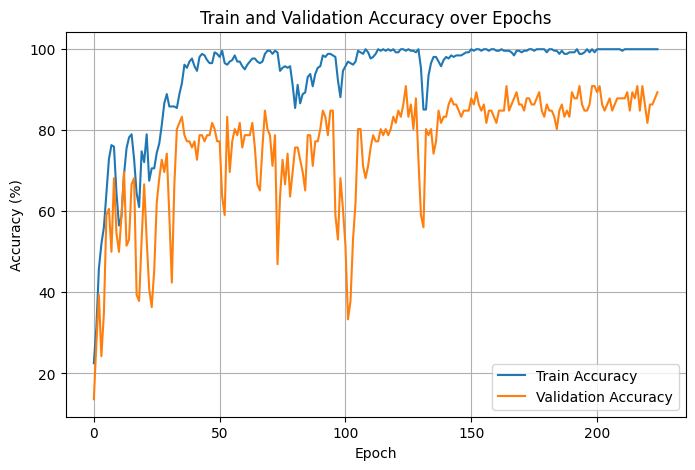

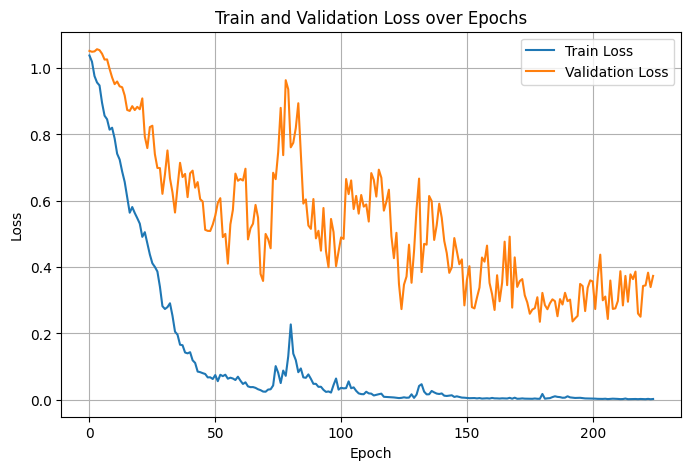

訓練完成！最佳 Val Acc: 90.91% (Epoch 125)
總訓練時間：2688.95 秒 ≈ 44.82 分鐘


In [4]:
# 訓練設置
NUM_EPOCHS = 300
LEARNING_RATE = 0.0003
PATIENCE = 100
MODEL_SAVE_PATH = "best_resnet18.pth"
CHECKPOINT_DIR = "Resnet18_checkpoints"

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Focal Loss 
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def train_one_epoch(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loader_tqdm.set_postfix(loss=loss.item())

    val_loss = running_loss / total
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

def compute_class_weights(dataset, device):
    label_list = dataset.labels
    counter = Counter(label_list)
    num_classes = len(counter)
    total_samples = sum(counter.values())
    class_counts = [counter[i] for i in range(num_classes)]
    weights = [total_samples / (num_classes * c) for c in class_counts]
    return torch.tensor(weights, dtype=torch.float).to(device)


def train_model(model, train_loader, val_loader, device):
    class_weights = compute_class_weights(train_loader.dataset, device)
    print("類別權重:", class_weights)

    criterion = FocalLoss(gamma=3.0, alpha=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

    warmup_epochs = 3
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - warmup_epochs, eta_min=5e-6)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None 
        start_time = time.time()
        
        if epoch < warmup_epochs:
            lr = LEARNING_RATE * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print(f"Warmup LR: {lr:.6f}")
        else:
            print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None 
        elapsed_time = time.time() - start_time
        epoch_times.append(elapsed_time)  
        print(f"Epoch Time: {elapsed_time:.2f} 秒")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if epoch >= warmup_epochs:
            scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")

        if (epoch + 1) % 50 == 0:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"--> 模型保存至 {checkpoint_path}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"--> 最佳模型保存 (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                total_time = sum(epoch_times)
                print(f"--> 早停於 Epoch {epoch+1}, 最佳 Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_acc, best_epoch, epoch_times 

def plot_accuracies(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('Image/pretraining_resnet18_accuracy_plot.png')
    plt.show()

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('Image/pretraining_resnet18_loss_plot.png')
    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_pretrained_resnet18(num_classes=6, freeze_backbone=False).to(device)
    
    train_losses, val_losses, train_accuracies, val_accuracies, best_val_acc, best_epoch, epoch_times = train_model(
        model, train_loader, val_loader, device
    )
    plot_accuracies(train_accuracies, val_accuracies)
    plot_losses(train_losses, val_losses)
    print(f"訓練完成！最佳 Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"總訓練時間：{sum(epoch_times):.2f} 秒 ≈ {sum(epoch_times)/60:.2f} 分鐘")

# 預訓練的EfficientNet

In [5]:
def get_pretrained_model(num_classes=6, freeze_backbone=False):
    model = timm.create_model("efficientnet_b0", pretrained=True)

    # 重設分類層（這會根據不同架構自動處理對應的 classifier/fc）
    model.reset_classifier(num_classes)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        # 只解凍分類層參數
        for param in model.get_classifier().parameters():
            param.requires_grad = True

    return model

類別權重: tensor([2.3768, 2.4848, 0.2496, 2.6032, 2.3768, 2.7333], device='cuda:0')

Epoch [1/300]
Warmup LR: 0.000100


Epoch Time: 8.99 秒
Train Loss: 1.0583, Train Acc: 8.78%
Val Loss:   1.0380, Val Acc:   3.03%
--> 最佳模型保存 (Val Acc: 3.03%)

Epoch [2/300]
Warmup LR: 0.000200


Epoch Time: 8.82 秒
Train Loss: 0.9062, Train Acc: 19.85%
Val Loss:   1.0325, Val Acc:   7.58%
--> 最佳模型保存 (Val Acc: 7.58%)

Epoch [3/300]
Warmup LR: 0.000300


Epoch Time: 8.78 秒
Train Loss: 0.7247, Train Acc: 46.56%
Val Loss:   1.0353, Val Acc:   9.09%
--> 最佳模型保存 (Val Acc: 9.09%)

Epoch [4/300]
Current LR: 0.000300


Epoch Time: 8.74 秒
Train Loss: 0.5561, Train Acc: 69.08%
Val Loss:   1.0506, Val Acc:   7.58%

Epoch [5/300]
Current LR: 0.000300


Epoch Time: 8.86 秒
Train Loss: 0.4263, Train Acc: 75.57%
Val Loss:   1.0242, Val Acc:   7.58%

Epoch [6/300]
Current LR: 0.000300


Epoch Time: 9.00 秒
Train Loss: 0.3597, Train Acc: 74.43%
Val Loss:   1.1058, Val Acc:   7.58%

Epoch [7/300]
Current LR: 0.000300


Epoch Time: 8.73 秒
Train Loss: 0.2802, Train Acc: 79.01%
Val Loss:   1.0669, Val Acc:   15.15%
--> 最佳模型保存 (Val Acc: 15.15%)

Epoch [8/300]
Current LR: 0.000300


Epoch Time: 8.66 秒
Train Loss: 0.2347, Train Acc: 75.57%
Val Loss:   1.0832, Val Acc:   21.21%
--> 最佳模型保存 (Val Acc: 21.21%)

Epoch [9/300]
Current LR: 0.000300


Epoch Time: 8.77 秒
Train Loss: 0.1923, Train Acc: 81.68%
Val Loss:   0.9154, Val Acc:   43.94%
--> 最佳模型保存 (Val Acc: 43.94%)

Epoch [10/300]
Current LR: 0.000300


Epoch Time: 8.76 秒
Train Loss: 0.1427, Train Acc: 85.88%
Val Loss:   0.7527, Val Acc:   60.61%
--> 最佳模型保存 (Val Acc: 60.61%)

Epoch [11/300]
Current LR: 0.000300


Epoch Time: 8.71 秒
Train Loss: 0.1041, Train Acc: 90.46%
Val Loss:   0.7557, Val Acc:   75.76%
--> 最佳模型保存 (Val Acc: 75.76%)

Epoch [12/300]
Current LR: 0.000299


Epoch Time: 8.78 秒
Train Loss: 0.0856, Train Acc: 92.75%
Val Loss:   0.8175, Val Acc:   78.79%
--> 最佳模型保存 (Val Acc: 78.79%)

Epoch [13/300]
Current LR: 0.000299


Epoch Time: 8.89 秒
Train Loss: 0.0731, Train Acc: 96.18%
Val Loss:   0.9261, Val Acc:   72.73%

Epoch [14/300]
Current LR: 0.000299


Epoch Time: 8.78 秒
Train Loss: 0.0663, Train Acc: 96.56%
Val Loss:   1.0002, Val Acc:   72.73%

Epoch [15/300]
Current LR: 0.000299


Epoch Time: 8.81 秒
Train Loss: 0.0283, Train Acc: 98.85%
Val Loss:   0.9822, Val Acc:   72.73%

Epoch [16/300]
Current LR: 0.000299


Epoch Time: 8.88 秒
Train Loss: 0.0224, Train Acc: 99.62%
Val Loss:   1.0998, Val Acc:   71.21%

Epoch [17/300]
Current LR: 0.000299


Epoch Time: 8.82 秒
Train Loss: 0.0370, Train Acc: 98.47%
Val Loss:   0.9958, Val Acc:   72.73%

Epoch [18/300]
Current LR: 0.000298


Epoch Time: 8.80 秒
Train Loss: 0.0163, Train Acc: 99.62%
Val Loss:   1.0140, Val Acc:   71.21%

Epoch [19/300]
Current LR: 0.000298


Epoch Time: 8.77 秒
Train Loss: 0.0330, Train Acc: 99.24%
Val Loss:   1.1674, Val Acc:   69.70%

Epoch [20/300]
Current LR: 0.000298


Epoch Time: 8.86 秒
Train Loss: 0.0424, Train Acc: 97.71%
Val Loss:   1.1340, Val Acc:   63.64%

Epoch [21/300]
Current LR: 0.000298


Epoch Time: 8.96 秒
Train Loss: 0.0574, Train Acc: 93.89%
Val Loss:   1.1245, Val Acc:   57.58%

Epoch [22/300]
Current LR: 0.000297


Epoch Time: 8.85 秒
Train Loss: 0.0616, Train Acc: 92.37%
Val Loss:   0.8759, Val Acc:   46.97%

Epoch [23/300]
Current LR: 0.000297


Epoch Time: 8.91 秒
Train Loss: 0.0452, Train Acc: 94.27%
Val Loss:   0.8269, Val Acc:   45.45%

Epoch [24/300]
Current LR: 0.000297


Epoch Time: 8.96 秒
Train Loss: 0.0434, Train Acc: 92.75%
Val Loss:   0.8504, Val Acc:   54.55%

Epoch [25/300]
Current LR: 0.000296


Epoch Time: 8.97 秒
Train Loss: 0.0303, Train Acc: 96.95%
Val Loss:   0.7569, Val Acc:   66.67%

Epoch [26/300]
Current LR: 0.000296


Epoch Time: 8.96 秒
Train Loss: 0.0249, Train Acc: 96.95%
Val Loss:   0.8670, Val Acc:   71.21%

Epoch [27/300]
Current LR: 0.000296


Epoch Time: 8.94 秒
Train Loss: 0.0186, Train Acc: 98.47%
Val Loss:   0.8071, Val Acc:   75.76%

Epoch [28/300]
Current LR: 0.000295


Epoch Time: 8.94 秒
Train Loss: 0.0137, Train Acc: 98.47%
Val Loss:   0.7175, Val Acc:   72.73%

Epoch [29/300]
Current LR: 0.000295


Epoch Time: 8.89 秒
Train Loss: 0.0100, Train Acc: 99.24%
Val Loss:   0.8026, Val Acc:   75.76%

Epoch [30/300]
Current LR: 0.000294


Epoch Time: 8.70 秒
Train Loss: 0.0075, Train Acc: 100.00%
Val Loss:   0.8424, Val Acc:   75.76%

Epoch [31/300]
Current LR: 0.000294


Epoch Time: 8.70 秒
Train Loss: 0.0063, Train Acc: 99.24%
Val Loss:   0.6356, Val Acc:   77.27%

Epoch [32/300]
Current LR: 0.000294


Epoch Time: 8.89 秒
Train Loss: 0.0044, Train Acc: 99.24%
Val Loss:   0.7618, Val Acc:   81.82%
--> 最佳模型保存 (Val Acc: 81.82%)

Epoch [33/300]
Current LR: 0.000293


Epoch Time: 8.78 秒
Train Loss: 0.0057, Train Acc: 99.62%
Val Loss:   0.8532, Val Acc:   78.79%

Epoch [34/300]
Current LR: 0.000293


Epoch Time: 9.08 秒
Train Loss: 0.0038, Train Acc: 99.62%
Val Loss:   0.9097, Val Acc:   78.79%

Epoch [35/300]
Current LR: 0.000292


Epoch Time: 8.92 秒
Train Loss: 0.0034, Train Acc: 100.00%
Val Loss:   0.7882, Val Acc:   74.24%

Epoch [36/300]
Current LR: 0.000292


Epoch Time: 8.87 秒
Train Loss: 0.0052, Train Acc: 99.62%
Val Loss:   0.7440, Val Acc:   77.27%

Epoch [37/300]
Current LR: 0.000291


Epoch Time: 8.84 秒
Train Loss: 0.0040, Train Acc: 99.62%
Val Loss:   0.8757, Val Acc:   71.21%

Epoch [38/300]
Current LR: 0.000291


Epoch Time: 8.91 秒
Train Loss: 0.0102, Train Acc: 96.95%
Val Loss:   0.9802, Val Acc:   71.21%

Epoch [39/300]
Current LR: 0.000290


Epoch Time: 8.94 秒
Train Loss: 0.0118, Train Acc: 96.56%
Val Loss:   1.0871, Val Acc:   71.21%

Epoch [40/300]
Current LR: 0.000289


Epoch Time: 8.89 秒
Train Loss: 0.0113, Train Acc: 96.18%
Val Loss:   0.8954, Val Acc:   69.70%

Epoch [41/300]
Current LR: 0.000289


Epoch Time: 8.86 秒
Train Loss: 0.0078, Train Acc: 99.24%
Val Loss:   0.9314, Val Acc:   71.21%

Epoch [42/300]
Current LR: 0.000288


Epoch Time: 8.84 秒
Train Loss: 0.0038, Train Acc: 99.62%
Val Loss:   0.7385, Val Acc:   80.30%

Epoch [43/300]
Current LR: 0.000288


Epoch Time: 8.91 秒
Train Loss: 0.0065, Train Acc: 98.85%
Val Loss:   0.7394, Val Acc:   78.79%

Epoch [44/300]
Current LR: 0.000287


Epoch Time: 8.89 秒
Train Loss: 0.0059, Train Acc: 98.85%
Val Loss:   0.6649, Val Acc:   80.30%

Epoch [45/300]
Current LR: 0.000286


Epoch Time: 8.85 秒
Train Loss: 0.0083, Train Acc: 97.71%
Val Loss:   0.5782, Val Acc:   78.79%

Epoch [46/300]
Current LR: 0.000286


Epoch Time: 8.79 秒
Train Loss: 0.0043, Train Acc: 98.85%
Val Loss:   0.6584, Val Acc:   74.24%

Epoch [47/300]
Current LR: 0.000285


Epoch Time: 8.79 秒
Train Loss: 0.0086, Train Acc: 98.09%
Val Loss:   0.5678, Val Acc:   78.79%

Epoch [48/300]
Current LR: 0.000284


Epoch Time: 8.89 秒
Train Loss: 0.0124, Train Acc: 96.95%
Val Loss:   0.6903, Val Acc:   77.27%

Epoch [49/300]
Current LR: 0.000284


Epoch Time: 8.88 秒
Train Loss: 0.0103, Train Acc: 96.95%
Val Loss:   0.5862, Val Acc:   77.27%

Epoch [50/300]
Current LR: 0.000283


Epoch Time: 8.80 秒
Train Loss: 0.0091, Train Acc: 98.09%
Val Loss:   0.5239, Val Acc:   74.24%
--> 模型保存至 EfficientNet_checkpoints/model_epoch_50.pth

Epoch [51/300]
Current LR: 0.000282


Epoch Time: 8.78 秒
Train Loss: 0.0040, Train Acc: 99.24%
Val Loss:   0.5584, Val Acc:   77.27%

Epoch [52/300]
Current LR: 0.000281


Epoch Time: 8.81 秒
Train Loss: 0.0029, Train Acc: 99.24%
Val Loss:   0.7021, Val Acc:   77.27%

Epoch [53/300]
Current LR: 0.000281


Epoch Time: 8.87 秒
Train Loss: 0.0052, Train Acc: 98.85%
Val Loss:   0.8278, Val Acc:   74.24%

Epoch [54/300]
Current LR: 0.000280


Epoch Time: 8.90 秒
Train Loss: 0.0040, Train Acc: 99.62%
Val Loss:   0.5756, Val Acc:   78.79%

Epoch [55/300]
Current LR: 0.000279


Epoch Time: 8.88 秒
Train Loss: 0.0050, Train Acc: 99.24%
Val Loss:   0.7698, Val Acc:   77.27%

Epoch [56/300]
Current LR: 0.000278


Epoch Time: 8.90 秒
Train Loss: 0.0055, Train Acc: 99.24%
Val Loss:   0.7160, Val Acc:   66.67%

Epoch [57/300]
Current LR: 0.000277


Epoch Time: 8.84 秒
Train Loss: 0.0036, Train Acc: 98.85%
Val Loss:   0.9634, Val Acc:   66.67%

Epoch [58/300]
Current LR: 0.000277


Epoch Time: 8.81 秒
Train Loss: 0.0090, Train Acc: 97.71%
Val Loss:   0.8882, Val Acc:   65.15%

Epoch [59/300]
Current LR: 0.000276


Epoch Time: 8.80 秒
Train Loss: 0.0073, Train Acc: 98.09%
Val Loss:   0.8606, Val Acc:   68.18%

Epoch [60/300]
Current LR: 0.000275


Epoch Time: 8.83 秒
Train Loss: 0.0104, Train Acc: 96.18%
Val Loss:   0.9322, Val Acc:   62.12%

Epoch [61/300]
Current LR: 0.000274


Epoch Time: 8.87 秒
Train Loss: 0.0216, Train Acc: 95.80%
Val Loss:   0.8619, Val Acc:   63.64%

Epoch [62/300]
Current LR: 0.000273


Epoch Time: 8.94 秒
Train Loss: 0.0197, Train Acc: 93.51%
Val Loss:   0.9215, Val Acc:   59.09%

Epoch [63/300]
Current LR: 0.000272


Epoch Time: 8.89 秒
Train Loss: 0.0123, Train Acc: 95.04%
Val Loss:   0.7773, Val Acc:   63.64%

Epoch [64/300]
Current LR: 0.000271


Epoch Time: 8.86 秒
Train Loss: 0.0095, Train Acc: 98.47%
Val Loss:   0.6831, Val Acc:   69.70%

Epoch [65/300]
Current LR: 0.000270


Epoch Time: 8.86 秒
Train Loss: 0.0068, Train Acc: 98.85%
Val Loss:   0.5656, Val Acc:   65.15%

Epoch [66/300]
Current LR: 0.000269


Epoch Time: 8.95 秒
Train Loss: 0.0058, Train Acc: 98.09%
Val Loss:   0.4500, Val Acc:   77.27%

Epoch [67/300]
Current LR: 0.000268


Epoch Time: 8.94 秒
Train Loss: 0.0096, Train Acc: 98.09%
Val Loss:   0.4131, Val Acc:   80.30%

Epoch [68/300]
Current LR: 0.000267


Epoch Time: 8.89 秒
Train Loss: 0.0276, Train Acc: 96.18%
Val Loss:   0.2751, Val Acc:   71.21%

Epoch [69/300]
Current LR: 0.000266


Epoch Time: 8.93 秒
Train Loss: 0.0280, Train Acc: 92.75%
Val Loss:   0.7466, Val Acc:   53.03%

Epoch [70/300]
Current LR: 0.000265


Epoch Time: 8.91 秒
Train Loss: 0.0779, Train Acc: 82.06%
Val Loss:   0.8561, Val Acc:   43.94%

Epoch [71/300]
Current LR: 0.000264


Epoch Time: 8.92 秒
Train Loss: 0.0945, Train Acc: 81.68%
Val Loss:   0.6989, Val Acc:   54.55%

Epoch [72/300]
Current LR: 0.000263


Epoch Time: 8.89 秒
Train Loss: 0.0571, Train Acc: 85.50%
Val Loss:   0.7212, Val Acc:   72.73%

Epoch [73/300]
Current LR: 0.000262


Epoch Time: 8.89 秒
Train Loss: 0.0515, Train Acc: 87.02%
Val Loss:   0.7822, Val Acc:   78.79%

Epoch [74/300]
Current LR: 0.000261


Epoch Time: 8.92 秒
Train Loss: 0.0272, Train Acc: 92.75%
Val Loss:   0.8774, Val Acc:   80.30%

Epoch [75/300]
Current LR: 0.000260


Epoch Time: 8.91 秒
Train Loss: 0.0155, Train Acc: 96.95%
Val Loss:   0.6221, Val Acc:   81.82%

Epoch [76/300]
Current LR: 0.000259


Epoch Time: 8.96 秒
Train Loss: 0.0112, Train Acc: 98.47%
Val Loss:   0.9004, Val Acc:   78.79%

Epoch [77/300]
Current LR: 0.000258


Epoch Time: 8.81 秒
Train Loss: 0.0086, Train Acc: 98.85%
Val Loss:   0.8839, Val Acc:   78.79%

Epoch [78/300]
Current LR: 0.000257


Epoch Time: 8.81 秒
Train Loss: 0.0139, Train Acc: 96.95%
Val Loss:   0.9357, Val Acc:   75.76%

Epoch [79/300]
Current LR: 0.000256


Epoch Time: 8.80 秒
Train Loss: 0.0145, Train Acc: 96.56%
Val Loss:   0.8222, Val Acc:   75.76%

Epoch [80/300]
Current LR: 0.000255


Epoch Time: 8.86 秒
Train Loss: 0.0081, Train Acc: 98.09%
Val Loss:   0.9439, Val Acc:   72.73%

Epoch [81/300]
Current LR: 0.000254


Epoch Time: 8.96 秒
Train Loss: 0.0049, Train Acc: 98.47%
Val Loss:   0.7448, Val Acc:   74.24%

Epoch [82/300]
Current LR: 0.000253


Epoch Time: 8.95 秒
Train Loss: 0.0031, Train Acc: 100.00%
Val Loss:   0.8976, Val Acc:   71.21%

Epoch [83/300]
Current LR: 0.000251


Epoch Time: 8.98 秒
Train Loss: 0.0125, Train Acc: 99.62%
Val Loss:   0.6846, Val Acc:   72.73%

Epoch [84/300]
Current LR: 0.000250


Epoch Time: 8.88 秒
Train Loss: 0.0170, Train Acc: 98.85%
Val Loss:   1.3355, Val Acc:   59.09%

Epoch [85/300]
Current LR: 0.000249


Epoch Time: 8.87 秒
Train Loss: 0.0763, Train Acc: 92.37%
Val Loss:   1.0929, Val Acc:   37.88%

Epoch [86/300]
Current LR: 0.000248


Epoch Time: 8.86 秒
Train Loss: 0.0624, Train Acc: 87.79%
Val Loss:   0.9896, Val Acc:   53.03%

Epoch [87/300]
Current LR: 0.000247


Epoch Time: 8.86 秒
Train Loss: 0.1133, Train Acc: 87.02%
Val Loss:   0.8464, Val Acc:   68.18%

Epoch [88/300]
Current LR: 0.000246


Epoch Time: 8.89 秒
Train Loss: 0.1193, Train Acc: 90.08%
Val Loss:   0.7397, Val Acc:   78.79%

Epoch [89/300]
Current LR: 0.000244


Epoch Time: 8.91 秒
Train Loss: 0.0691, Train Acc: 93.89%
Val Loss:   0.6941, Val Acc:   78.79%

Epoch [90/300]
Current LR: 0.000243


Epoch Time: 8.88 秒
Train Loss: 0.0284, Train Acc: 98.09%
Val Loss:   0.5503, Val Acc:   78.79%

Epoch [91/300]
Current LR: 0.000242


Epoch Time: 8.88 秒
Train Loss: 0.0169, Train Acc: 96.95%
Val Loss:   0.6298, Val Acc:   71.21%

Epoch [92/300]
Current LR: 0.000241


Epoch Time: 8.87 秒
Train Loss: 0.0255, Train Acc: 94.66%
Val Loss:   0.6282, Val Acc:   74.24%

Epoch [93/300]
Current LR: 0.000239


Epoch Time: 8.83 秒
Train Loss: 0.0224, Train Acc: 92.37%
Val Loss:   0.5553, Val Acc:   65.15%

Epoch [94/300]
Current LR: 0.000238


Epoch Time: 8.88 秒
Train Loss: 0.0178, Train Acc: 92.75%
Val Loss:   0.7049, Val Acc:   57.58%

Epoch [95/300]
Current LR: 0.000237


Epoch Time: 8.88 秒
Train Loss: 0.0184, Train Acc: 92.37%
Val Loss:   0.3861, Val Acc:   71.21%

Epoch [96/300]
Current LR: 0.000235


Epoch Time: 8.91 秒
Train Loss: 0.0162, Train Acc: 93.13%
Val Loss:   0.4885, Val Acc:   69.70%

Epoch [97/300]
Current LR: 0.000234


Epoch Time: 8.89 秒
Train Loss: 0.0164, Train Acc: 94.66%
Val Loss:   0.6473, Val Acc:   72.73%

Epoch [98/300]
Current LR: 0.000233


Epoch Time: 8.88 秒
Train Loss: 0.0098, Train Acc: 98.09%
Val Loss:   0.5389, Val Acc:   83.33%
--> 最佳模型保存 (Val Acc: 83.33%)

Epoch [99/300]
Current LR: 0.000232


Epoch Time: 8.88 秒
Train Loss: 0.0227, Train Acc: 96.56%
Val Loss:   0.8167, Val Acc:   68.18%

Epoch [100/300]
Current LR: 0.000230


Epoch Time: 8.91 秒
Train Loss: 0.0379, Train Acc: 88.17%
Val Loss:   0.7140, Val Acc:   62.12%
--> 模型保存至 EfficientNet_checkpoints/model_epoch_100.pth

Epoch [101/300]
Current LR: 0.000229


Epoch Time: 8.95 秒
Train Loss: 0.0586, Train Acc: 85.50%
Val Loss:   0.5128, Val Acc:   80.30%

Epoch [102/300]
Current LR: 0.000228


Epoch Time: 8.98 秒
Train Loss: 0.0247, Train Acc: 93.89%
Val Loss:   1.0854, Val Acc:   65.15%

Epoch [103/300]
Current LR: 0.000226


Epoch Time: 8.96 秒
Train Loss: 0.0772, Train Acc: 91.22%
Val Loss:   0.6401, Val Acc:   72.73%

Epoch [104/300]
Current LR: 0.000225


Epoch Time: 8.94 秒
Train Loss: 0.0919, Train Acc: 93.13%
Val Loss:   0.9504, Val Acc:   75.76%

Epoch [105/300]
Current LR: 0.000224


Epoch Time: 8.94 秒
Train Loss: 0.0515, Train Acc: 95.42%
Val Loss:   0.7140, Val Acc:   72.73%

Epoch [106/300]
Current LR: 0.000222


Epoch Time: 8.88 秒
Train Loss: 0.0317, Train Acc: 96.18%
Val Loss:   0.8959, Val Acc:   72.73%

Epoch [107/300]
Current LR: 0.000221


Epoch Time: 8.91 秒
Train Loss: 0.0154, Train Acc: 97.33%
Val Loss:   0.9675, Val Acc:   68.18%

Epoch [108/300]
Current LR: 0.000219


Epoch Time: 8.81 秒
Train Loss: 0.0396, Train Acc: 96.18%
Val Loss:   1.1271, Val Acc:   69.70%

Epoch [109/300]
Current LR: 0.000218


Epoch Time: 8.95 秒
Train Loss: 0.0094, Train Acc: 98.09%
Val Loss:   0.8121, Val Acc:   71.21%

Epoch [110/300]
Current LR: 0.000217


Epoch Time: 8.84 秒
Train Loss: 0.0194, Train Acc: 95.42%
Val Loss:   0.7577, Val Acc:   72.73%

Epoch [111/300]
Current LR: 0.000215


Epoch Time: 8.79 秒
Train Loss: 0.0140, Train Acc: 95.04%
Val Loss:   0.6738, Val Acc:   77.27%

Epoch [112/300]
Current LR: 0.000214


Epoch Time: 8.84 秒
Train Loss: 0.0139, Train Acc: 95.42%
Val Loss:   0.6196, Val Acc:   77.27%

Epoch [113/300]
Current LR: 0.000212


Epoch Time: 8.92 秒
Train Loss: 0.0118, Train Acc: 96.56%
Val Loss:   0.6157, Val Acc:   81.82%

Epoch [114/300]
Current LR: 0.000211


Epoch Time: 8.86 秒
Train Loss: 0.0067, Train Acc: 97.71%
Val Loss:   0.3760, Val Acc:   87.88%
--> 最佳模型保存 (Val Acc: 87.88%)

Epoch [115/300]
Current LR: 0.000209


Epoch Time: 8.82 秒
Train Loss: 0.0100, Train Acc: 97.33%
Val Loss:   0.4619, Val Acc:   83.33%

Epoch [116/300]
Current LR: 0.000208


Epoch Time: 8.84 秒
Train Loss: 0.0050, Train Acc: 98.85%
Val Loss:   0.5388, Val Acc:   84.85%

Epoch [117/300]
Current LR: 0.000207


Epoch Time: 8.84 秒
Train Loss: 0.0044, Train Acc: 98.85%
Val Loss:   0.3206, Val Acc:   87.88%

Epoch [118/300]
Current LR: 0.000205


Epoch Time: 8.84 秒
Train Loss: 0.0071, Train Acc: 99.24%
Val Loss:   0.5754, Val Acc:   86.36%

Epoch [119/300]
Current LR: 0.000204


Epoch Time: 8.89 秒
Train Loss: 0.0214, Train Acc: 98.85%
Val Loss:   0.4091, Val Acc:   84.85%

Epoch [120/300]
Current LR: 0.000202


Epoch Time: 8.90 秒
Train Loss: 0.0027, Train Acc: 99.24%
Val Loss:   0.5308, Val Acc:   86.36%

Epoch [121/300]
Current LR: 0.000201


Epoch Time: 8.91 秒
Train Loss: 0.0329, Train Acc: 97.71%
Val Loss:   0.5900, Val Acc:   72.73%

Epoch [122/300]
Current LR: 0.000199


Epoch Time: 8.85 秒
Train Loss: 0.0129, Train Acc: 94.27%
Val Loss:   0.9979, Val Acc:   62.12%

Epoch [123/300]
Current LR: 0.000198


Epoch Time: 8.85 秒
Train Loss: 0.0335, Train Acc: 90.08%
Val Loss:   0.9946, Val Acc:   60.61%

Epoch [124/300]
Current LR: 0.000196


Epoch Time: 8.83 秒
Train Loss: 0.0429, Train Acc: 89.31%
Val Loss:   0.8539, Val Acc:   74.24%

Epoch [125/300]
Current LR: 0.000195


Epoch Time: 8.83 秒
Train Loss: 0.0526, Train Acc: 90.46%
Val Loss:   0.5883, Val Acc:   72.73%

Epoch [126/300]
Current LR: 0.000193


Epoch Time: 8.79 秒
Train Loss: 0.0296, Train Acc: 91.98%
Val Loss:   0.6679, Val Acc:   75.76%

Epoch [127/300]
Current LR: 0.000192


Epoch Time: 8.76 秒
Train Loss: 0.0285, Train Acc: 92.37%
Val Loss:   0.5356, Val Acc:   80.30%

Epoch [128/300]
Current LR: 0.000190


Epoch Time: 8.73 秒
Train Loss: 0.0243, Train Acc: 92.75%
Val Loss:   0.4484, Val Acc:   84.85%

Epoch [129/300]
Current LR: 0.000189


Epoch Time: 8.78 秒
Train Loss: 0.0275, Train Acc: 96.56%
Val Loss:   0.5477, Val Acc:   86.36%

Epoch [130/300]
Current LR: 0.000187


Epoch Time: 8.94 秒
Train Loss: 0.0174, Train Acc: 95.04%
Val Loss:   0.3897, Val Acc:   89.39%
--> 最佳模型保存 (Val Acc: 89.39%)

Epoch [131/300]
Current LR: 0.000186


Epoch Time: 8.94 秒
Train Loss: 0.0107, Train Acc: 98.85%
Val Loss:   0.4460, Val Acc:   86.36%

Epoch [132/300]
Current LR: 0.000184


Epoch Time: 8.89 秒
Train Loss: 0.0146, Train Acc: 97.33%
Val Loss:   0.4478, Val Acc:   84.85%

Epoch [133/300]
Current LR: 0.000183


Epoch Time: 8.86 秒
Train Loss: 0.0108, Train Acc: 96.56%
Val Loss:   0.5080, Val Acc:   83.33%

Epoch [134/300]
Current LR: 0.000181


Epoch Time: 8.83 秒
Train Loss: 0.0105, Train Acc: 98.85%
Val Loss:   0.5813, Val Acc:   84.85%

Epoch [135/300]
Current LR: 0.000180


Epoch Time: 8.74 秒
Train Loss: 0.0057, Train Acc: 98.85%
Val Loss:   0.6146, Val Acc:   78.79%

Epoch [136/300]
Current LR: 0.000178


Epoch Time: 8.71 秒
Train Loss: 0.0075, Train Acc: 96.95%
Val Loss:   0.6157, Val Acc:   81.82%

Epoch [137/300]
Current LR: 0.000177


Epoch Time: 8.79 秒
Train Loss: 0.0189, Train Acc: 97.33%
Val Loss:   0.5874, Val Acc:   83.33%

Epoch [138/300]
Current LR: 0.000175


Epoch Time: 8.79 秒
Train Loss: 0.0070, Train Acc: 98.09%
Val Loss:   0.6380, Val Acc:   84.85%

Epoch [139/300]
Current LR: 0.000173


Epoch Time: 8.86 秒
Train Loss: 0.0165, Train Acc: 95.80%
Val Loss:   0.5749, Val Acc:   86.36%

Epoch [140/300]
Current LR: 0.000172


Epoch Time: 8.79 秒
Train Loss: 0.0150, Train Acc: 95.04%
Val Loss:   0.6391, Val Acc:   80.30%

Epoch [141/300]
Current LR: 0.000170


Epoch Time: 8.74 秒
Train Loss: 0.0087, Train Acc: 98.09%
Val Loss:   0.5647, Val Acc:   83.33%

Epoch [142/300]
Current LR: 0.000169


Epoch Time: 8.76 秒
Train Loss: 0.0058, Train Acc: 98.85%
Val Loss:   0.6863, Val Acc:   84.85%

Epoch [143/300]
Current LR: 0.000167


Epoch Time: 8.87 秒
Train Loss: 0.0062, Train Acc: 97.71%
Val Loss:   0.5933, Val Acc:   83.33%

Epoch [144/300]
Current LR: 0.000166


Epoch Time: 8.91 秒
Train Loss: 0.0038, Train Acc: 98.47%
Val Loss:   0.6526, Val Acc:   81.82%

Epoch [145/300]
Current LR: 0.000164


Epoch Time: 8.82 秒
Train Loss: 0.0032, Train Acc: 98.85%
Val Loss:   0.6098, Val Acc:   80.30%

Epoch [146/300]
Current LR: 0.000163


Epoch Time: 8.98 秒
Train Loss: 0.0027, Train Acc: 99.24%
Val Loss:   0.6816, Val Acc:   80.30%

Epoch [147/300]
Current LR: 0.000161


Epoch Time: 8.93 秒
Train Loss: 0.0024, Train Acc: 100.00%
Val Loss:   0.6979, Val Acc:   83.33%

Epoch [148/300]
Current LR: 0.000160


Epoch Time: 8.88 秒
Train Loss: 0.0022, Train Acc: 99.62%
Val Loss:   0.5890, Val Acc:   83.33%

Epoch [149/300]
Current LR: 0.000158


Epoch Time: 8.89 秒
Train Loss: 0.0024, Train Acc: 100.00%
Val Loss:   0.6986, Val Acc:   83.33%

Epoch [150/300]
Current LR: 0.000156


Epoch Time: 8.95 秒
Train Loss: 0.0020, Train Acc: 100.00%
Val Loss:   0.6026, Val Acc:   84.85%
--> 模型保存至 EfficientNet_checkpoints/model_epoch_150.pth

Epoch [151/300]
Current LR: 0.000155


Epoch Time: 8.94 秒
Train Loss: 0.0013, Train Acc: 100.00%
Val Loss:   0.6707, Val Acc:   80.30%

Epoch [152/300]
Current LR: 0.000153


Epoch Time: 8.95 秒
Train Loss: 0.0019, Train Acc: 99.62%
Val Loss:   0.5336, Val Acc:   78.79%

Epoch [153/300]
Current LR: 0.000152


Epoch Time: 8.89 秒
Train Loss: 0.0011, Train Acc: 100.00%
Val Loss:   0.7351, Val Acc:   78.79%

Epoch [154/300]
Current LR: 0.000150


Epoch Time: 8.88 秒
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss:   0.6543, Val Acc:   80.30%

Epoch [155/300]
Current LR: 0.000149


Epoch Time: 8.88 秒
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss:   0.5619, Val Acc:   78.79%

Epoch [156/300]
Current LR: 0.000147


Epoch Time: 8.87 秒
Train Loss: 0.0008, Train Acc: 100.00%
Val Loss:   0.5749, Val Acc:   80.30%

Epoch [157/300]
Current LR: 0.000145


Epoch Time: 8.87 秒
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss:   0.5665, Val Acc:   84.85%

Epoch [158/300]
Current LR: 0.000144


Epoch Time: 8.91 秒
Train Loss: 0.0019, Train Acc: 100.00%
Val Loss:   0.5705, Val Acc:   80.30%

Epoch [159/300]
Current LR: 0.000142


Epoch Time: 8.90 秒
Train Loss: 0.0007, Train Acc: 100.00%
Val Loss:   0.5405, Val Acc:   84.85%

Epoch [160/300]
Current LR: 0.000141


Epoch Time: 8.93 秒
Train Loss: 0.0007, Train Acc: 100.00%
Val Loss:   0.6065, Val Acc:   84.85%

Epoch [161/300]
Current LR: 0.000139


Epoch Time: 8.94 秒
Train Loss: 0.0009, Train Acc: 99.62%
Val Loss:   0.5833, Val Acc:   83.33%

Epoch [162/300]
Current LR: 0.000138


Epoch Time: 8.93 秒
Train Loss: 0.0007, Train Acc: 100.00%
Val Loss:   0.6140, Val Acc:   86.36%

Epoch [163/300]
Current LR: 0.000136


Epoch Time: 8.93 秒
Train Loss: 0.0007, Train Acc: 100.00%
Val Loss:   0.5520, Val Acc:   86.36%

Epoch [164/300]
Current LR: 0.000135


Epoch Time: 8.98 秒
Train Loss: 0.0013, Train Acc: 99.24%
Val Loss:   0.6575, Val Acc:   86.36%

Epoch [165/300]
Current LR: 0.000133


Epoch Time: 8.91 秒
Train Loss: 0.0010, Train Acc: 99.62%
Val Loss:   0.6512, Val Acc:   84.85%

Epoch [166/300]
Current LR: 0.000132


Epoch Time: 8.87 秒
Train Loss: 0.0090, Train Acc: 99.24%
Val Loss:   0.7721, Val Acc:   81.82%

Epoch [167/300]
Current LR: 0.000130


Epoch Time: 8.89 秒
Train Loss: 0.0034, Train Acc: 99.24%
Val Loss:   0.7263, Val Acc:   81.82%

Epoch [168/300]
Current LR: 0.000128


Epoch Time: 8.95 秒
Train Loss: 0.0135, Train Acc: 98.85%
Val Loss:   0.7531, Val Acc:   81.82%

Epoch [169/300]
Current LR: 0.000127


Epoch Time: 8.99 秒
Train Loss: 0.0178, Train Acc: 98.85%
Val Loss:   0.7278, Val Acc:   81.82%

Epoch [170/300]
Current LR: 0.000125


Epoch Time: 8.95 秒
Train Loss: 0.0094, Train Acc: 99.24%
Val Loss:   0.6879, Val Acc:   83.33%

Epoch [171/300]
Current LR: 0.000124


Epoch Time: 8.91 秒
Train Loss: 0.0252, Train Acc: 98.47%
Val Loss:   0.6764, Val Acc:   81.82%

Epoch [172/300]
Current LR: 0.000122


Epoch Time: 8.93 秒
Train Loss: 0.0100, Train Acc: 98.47%
Val Loss:   0.7143, Val Acc:   78.79%

Epoch [173/300]
Current LR: 0.000121


Epoch Time: 8.92 秒
Train Loss: 0.0061, Train Acc: 99.24%
Val Loss:   0.7779, Val Acc:   83.33%

Epoch [174/300]
Current LR: 0.000119


Epoch Time: 8.92 秒
Train Loss: 0.0258, Train Acc: 98.85%
Val Loss:   0.7125, Val Acc:   78.79%

Epoch [175/300]
Current LR: 0.000118


Epoch Time: 8.93 秒
Train Loss: 0.0033, Train Acc: 99.62%
Val Loss:   0.6159, Val Acc:   81.82%

Epoch [176/300]
Current LR: 0.000116


Epoch Time: 8.87 秒
Train Loss: 0.0054, Train Acc: 98.47%
Val Loss:   0.5707, Val Acc:   83.33%

Epoch [177/300]
Current LR: 0.000115


Epoch Time: 8.86 秒
Train Loss: 0.0037, Train Acc: 98.85%
Val Loss:   0.5186, Val Acc:   80.30%

Epoch [178/300]
Current LR: 0.000113


Epoch Time: 8.93 秒
Train Loss: 0.0118, Train Acc: 96.95%
Val Loss:   0.5072, Val Acc:   83.33%

Epoch [179/300]
Current LR: 0.000112


Epoch Time: 9.00 秒
Train Loss: 0.0614, Train Acc: 96.95%
Val Loss:   0.6547, Val Acc:   77.27%

Epoch [180/300]
Current LR: 0.000110


Epoch Time: 8.87 秒
Train Loss: 0.0051, Train Acc: 99.24%
Val Loss:   0.4729, Val Acc:   77.27%

Epoch [181/300]
Current LR: 0.000109


Epoch Time: 8.88 秒
Train Loss: 0.0089, Train Acc: 98.09%
Val Loss:   0.4836, Val Acc:   72.73%

Epoch [182/300]
Current LR: 0.000107


Epoch Time: 8.93 秒
Train Loss: 0.0108, Train Acc: 97.71%
Val Loss:   0.5990, Val Acc:   71.21%

Epoch [183/300]
Current LR: 0.000106


Epoch Time: 8.93 秒
Train Loss: 0.0131, Train Acc: 96.56%
Val Loss:   0.4813, Val Acc:   72.73%

Epoch [184/300]
Current LR: 0.000104


Epoch Time: 8.99 秒
Train Loss: 0.0183, Train Acc: 95.42%
Val Loss:   0.5932, Val Acc:   71.21%

Epoch [185/300]
Current LR: 0.000103


Epoch Time: 8.93 秒
Train Loss: 0.0506, Train Acc: 97.71%
Val Loss:   0.5047, Val Acc:   75.76%

Epoch [186/300]
Current LR: 0.000101


Epoch Time: 8.95 秒
Train Loss: 0.0414, Train Acc: 95.42%
Val Loss:   0.4806, Val Acc:   81.82%

Epoch [187/300]
Current LR: 0.000100


Epoch Time: 8.88 秒
Train Loss: 0.0106, Train Acc: 98.09%
Val Loss:   0.5229, Val Acc:   77.27%

Epoch [188/300]
Current LR: 0.000098


Epoch Time: 8.94 秒
Train Loss: 0.0220, Train Acc: 95.80%
Val Loss:   0.6010, Val Acc:   78.79%

Epoch [189/300]
Current LR: 0.000097


Epoch Time: 8.94 秒
Train Loss: 0.0114, Train Acc: 98.09%
Val Loss:   0.5643, Val Acc:   86.36%

Epoch [190/300]
Current LR: 0.000096


Epoch Time: 8.92 秒
Train Loss: 0.0074, Train Acc: 99.24%
Val Loss:   0.6476, Val Acc:   84.85%

Epoch [191/300]
Current LR: 0.000094


Epoch Time: 8.96 秒
Train Loss: 0.0069, Train Acc: 96.56%
Val Loss:   0.6049, Val Acc:   84.85%

Epoch [192/300]
Current LR: 0.000093


Epoch Time: 8.89 秒
Train Loss: 0.0113, Train Acc: 98.85%
Val Loss:   0.6176, Val Acc:   84.85%

Epoch [193/300]
Current LR: 0.000091


Epoch Time: 8.87 秒
Train Loss: 0.0048, Train Acc: 97.71%
Val Loss:   0.4871, Val Acc:   84.85%

Epoch [194/300]
Current LR: 0.000090


Epoch Time: 8.91 秒
Train Loss: 0.0035, Train Acc: 98.09%
Val Loss:   0.5028, Val Acc:   83.33%

Epoch [195/300]
Current LR: 0.000088


Epoch Time: 8.97 秒
Train Loss: 0.0052, Train Acc: 99.24%
Val Loss:   0.5504, Val Acc:   80.30%

Epoch [196/300]
Current LR: 0.000087


Epoch Time: 8.93 秒
Train Loss: 0.0066, Train Acc: 97.71%
Val Loss:   0.4961, Val Acc:   81.82%

Epoch [197/300]
Current LR: 0.000086


Epoch Time: 8.93 秒
Train Loss: 0.0027, Train Acc: 99.62%
Val Loss:   0.5194, Val Acc:   81.82%

Epoch [198/300]
Current LR: 0.000084


Epoch Time: 8.93 秒
Train Loss: 0.0028, Train Acc: 99.62%
Val Loss:   0.5430, Val Acc:   81.82%

Epoch [199/300]
Current LR: 0.000083


Epoch Time: 8.92 秒
Train Loss: 0.0027, Train Acc: 98.85%
Val Loss:   0.4674, Val Acc:   84.85%

Epoch [200/300]
Current LR: 0.000081


Epoch Time: 8.89 秒
Train Loss: 0.0023, Train Acc: 99.62%
Val Loss:   0.4873, Val Acc:   86.36%
--> 模型保存至 EfficientNet_checkpoints/model_epoch_200.pth

Epoch [201/300]
Current LR: 0.000080


Epoch Time: 8.88 秒
Train Loss: 0.0023, Train Acc: 99.62%
Val Loss:   0.6027, Val Acc:   83.33%

Epoch [202/300]
Current LR: 0.000079


Epoch Time: 8.87 秒
Train Loss: 0.0024, Train Acc: 99.62%
Val Loss:   0.5311, Val Acc:   86.36%

Epoch [203/300]
Current LR: 0.000077


Epoch Time: 8.92 秒
Train Loss: 0.0021, Train Acc: 100.00%
Val Loss:   0.5148, Val Acc:   84.85%

Epoch [204/300]
Current LR: 0.000076


Epoch Time: 9.10 秒
Train Loss: 0.0021, Train Acc: 99.62%
Val Loss:   0.4798, Val Acc:   83.33%

Epoch [205/300]
Current LR: 0.000075


Epoch Time: 9.16 秒
Train Loss: 0.0012, Train Acc: 100.00%
Val Loss:   0.6059, Val Acc:   83.33%

Epoch [206/300]
Current LR: 0.000073


Epoch Time: 9.16 秒
Train Loss: 0.0017, Train Acc: 100.00%
Val Loss:   0.4272, Val Acc:   83.33%

Epoch [207/300]
Current LR: 0.000072


Epoch Time: 9.17 秒
Train Loss: 0.0012, Train Acc: 99.62%
Val Loss:   0.6588, Val Acc:   81.82%

Epoch [208/300]
Current LR: 0.000071


Epoch Time: 9.05 秒
Train Loss: 0.0011, Train Acc: 100.00%
Val Loss:   0.5442, Val Acc:   80.30%

Epoch [209/300]
Current LR: 0.000070


Epoch Time: 8.90 秒
Train Loss: 0.0016, Train Acc: 99.24%
Val Loss:   0.4757, Val Acc:   87.88%

Epoch [210/300]
Current LR: 0.000068


Epoch Time: 8.87 秒
Train Loss: 0.0012, Train Acc: 100.00%
Val Loss:   0.5022, Val Acc:   83.33%

Epoch [211/300]
Current LR: 0.000067


Epoch Time: 8.86 秒
Train Loss: 0.0012, Train Acc: 100.00%
Val Loss:   0.5828, Val Acc:   81.82%

Epoch [212/300]
Current LR: 0.000066


Epoch Time: 8.79 秒
Train Loss: 0.0013, Train Acc: 99.62%
Val Loss:   0.4255, Val Acc:   84.85%

Epoch [213/300]
Current LR: 0.000064


Epoch Time: 8.93 秒
Train Loss: 0.0035, Train Acc: 99.62%
Val Loss:   0.4735, Val Acc:   83.33%

Epoch [214/300]
Current LR: 0.000063


Epoch Time: 8.82 秒
Train Loss: 0.0054, Train Acc: 99.62%
Val Loss:   0.5429, Val Acc:   84.85%

Epoch [215/300]
Current LR: 0.000062


Epoch Time: 8.83 秒
Train Loss: 0.0017, Train Acc: 100.00%
Val Loss:   0.4409, Val Acc:   83.33%

Epoch [216/300]
Current LR: 0.000061


Epoch Time: 8.77 秒
Train Loss: 0.0014, Train Acc: 100.00%
Val Loss:   0.4202, Val Acc:   86.36%

Epoch [217/300]
Current LR: 0.000059


Epoch Time: 8.73 秒
Train Loss: 0.0013, Train Acc: 100.00%
Val Loss:   0.5471, Val Acc:   83.33%

Epoch [218/300]
Current LR: 0.000058


Epoch Time: 8.83 秒
Train Loss: 0.0028, Train Acc: 99.62%
Val Loss:   0.4923, Val Acc:   84.85%

Epoch [219/300]
Current LR: 0.000057


Epoch Time: 8.77 秒
Train Loss: 0.0011, Train Acc: 100.00%
Val Loss:   0.5006, Val Acc:   86.36%

Epoch [220/300]
Current LR: 0.000056


Epoch Time: 8.81 秒
Train Loss: 0.0010, Train Acc: 100.00%
Val Loss:   0.5041, Val Acc:   80.30%

Epoch [221/300]
Current LR: 0.000055


Epoch Time: 8.82 秒
Train Loss: 0.0017, Train Acc: 99.62%
Val Loss:   0.4231, Val Acc:   84.85%

Epoch [222/300]
Current LR: 0.000054


Epoch Time: 8.82 秒
Train Loss: 0.0015, Train Acc: 99.24%
Val Loss:   0.3900, Val Acc:   83.33%

Epoch [223/300]
Current LR: 0.000052


Epoch Time: 8.83 秒
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss:   0.4151, Val Acc:   83.33%

Epoch [224/300]
Current LR: 0.000051


Epoch Time: 8.81 秒
Train Loss: 0.0010, Train Acc: 99.62%
Val Loss:   0.5156, Val Acc:   83.33%

Epoch [225/300]
Current LR: 0.000050


Epoch Time: 8.82 秒
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss:   0.4381, Val Acc:   87.88%

Epoch [226/300]
Current LR: 0.000049


Epoch Time: 8.80 秒
Train Loss: 0.0023, Train Acc: 100.00%
Val Loss:   0.4764, Val Acc:   84.85%

Epoch [227/300]
Current LR: 0.000048


Epoch Time: 8.77 秒
Train Loss: 0.0018, Train Acc: 100.00%
Val Loss:   0.4520, Val Acc:   84.85%

Epoch [228/300]
Current LR: 0.000047


Epoch Time: 8.83 秒
Train Loss: 0.0008, Train Acc: 100.00%
Val Loss:   0.5243, Val Acc:   84.85%

Epoch [229/300]
Current LR: 0.000046


Epoch Time: 8.80 秒
Train Loss: 0.0014, Train Acc: 100.00%
Val Loss:   0.5053, Val Acc:   84.85%

Epoch [230/300]
Current LR: 0.000045


Epoch Time: 8.85 秒
Train Loss: 0.0106, Train Acc: 99.24%
Val Loss:   0.4753, Val Acc:   84.85%
--> 早停於 Epoch 230, 最佳 Val Acc: 89.39% (Epoch 130)


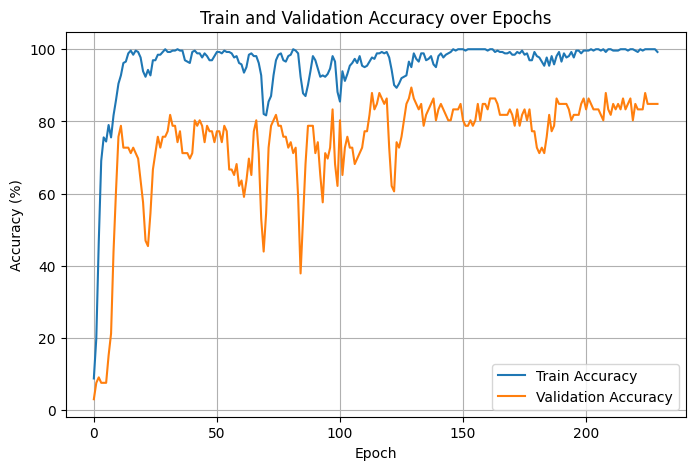

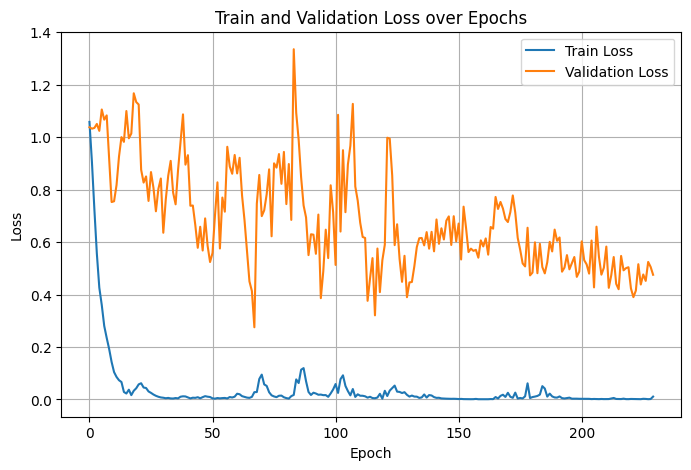

訓練完成！最佳 Val Acc: 89.39% (Epoch 130)
總訓練時間：2041.89 秒 ≈ 34.03 分鐘


In [6]:
# 訓練設置
NUM_EPOCHS = 300
LEARNING_RATE = 0.0003
PATIENCE = 100
MODEL_SAVE_PATH = "best_EfficientNet.pth"
CHECKPOINT_DIR = "EfficientNet_checkpoints"

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Focal Loss 
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def train_one_epoch(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loader_tqdm.set_postfix(loss=loss.item())

    val_loss = running_loss / total
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

def compute_class_weights(dataset, device):
    label_list = dataset.labels
    counter = Counter(label_list)
    num_classes = len(counter)
    total_samples = sum(counter.values())
    class_counts = [counter[i] for i in range(num_classes)]
    weights = [total_samples / (num_classes * c) for c in class_counts]
    return torch.tensor(weights, dtype=torch.float).to(device)


def train_model(model, train_loader, val_loader, device):
    class_weights = compute_class_weights(train_loader.dataset, device)
    print("類別權重:", class_weights)

    criterion = FocalLoss(gamma=3.0, alpha=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

    warmup_epochs = 3
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - warmup_epochs, eta_min=5e-6)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None  # 精準時間測量
        start_time = time.time()
        
        if epoch < warmup_epochs:
            lr = LEARNING_RATE * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print(f"Warmup LR: {lr:.6f}")
        else:
            print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None 
        elapsed_time = time.time() - start_time
        epoch_times.append(elapsed_time) 
        print(f"Epoch Time: {elapsed_time:.2f} 秒")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if epoch >= warmup_epochs:
            scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")

        if (epoch + 1) % 50 == 0:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"--> 模型保存至 {checkpoint_path}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"--> 最佳模型保存 (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                total_time = sum(epoch_times)
                print(f"--> 早停於 Epoch {epoch+1}, 最佳 Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_acc, best_epoch, epoch_times

def plot_accuracies(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('Image/efficientNet_accuracy_plot.png')
    plt.show()

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('Image/efficientNe_loss_plot.png')
    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_pretrained_model(num_classes=6, freeze_backbone=False).to(device)
    
    train_losses, val_losses, train_accuracies, val_accuracies, best_val_acc, best_epoch, epoch_times = train_model(
        model, train_loader, val_loader, device
    )
    plot_accuracies(train_accuracies, val_accuracies)
    plot_losses(train_losses, val_losses)
    print(f"訓練完成！最佳 Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"總訓練時間：{sum(epoch_times):.2f} 秒 ≈ {sum(epoch_times)/60:.2f} 分鐘")